# VenueSignal - Yelp Business Rating Prediction
### AAI-540 Group 6 

---

## Project Overview

This notebook implements a complete end-to-end MLOps pipeline for predicting Yelp business ratings with a focus on parking availability constraints. The pipeline demonstrates MLOps best practices including:

- **Data Lake Management**: S3-based data storage with proper versioning
- **Data Cataloging**: Athena tables for queryable data access
- **Feature Engineering**: Scalable feature store implementation
- **Model Development**: Baseline and advanced models with proper evaluation
- **Model Deployment**: SageMaker endpoints for inference
- **Monitoring**: Comprehensive model, data, and infrastructure monitoring

**Key Feature**: Uses AWS Account ID for bucket naming to enable each team member to run independently in their own AWS Learning Lab environment.

---

## Table of Contents

1. [Setup & Configuration](#section-1)
2. [Data Lake Setup](#section-2)
3. [Athena Tables & Data Cataloging](#section-3)
4. [Exploratory Data Analysis](#section-4)
5. [Feature Engineering & Feature Store](#section-5)
6. [Model Training](#section-6)
   - 6.1 Benchmark Models
   - 6.2 XGBoost Model
   - 6.3 Model Comparison
7. [Model Deployment](#section-7)
8. [Monitoring & Observability](#section-8)

---

## 1. Setup & Configuration <a id='section-1'></a>

This section:
- Verifies Python version
- Imports all required libraries
- Retrieves AWS Account ID for unique resource naming
- Initializes AWS clients and SageMaker session
- Configures S3 buckets using Account ID pattern

In [6]:
# Verify Python version
!python --version

Python 3.12.9


### 1.1 Import Required Libraries

In [7]:
# Standard libraries
import pandas as pd
import numpy as np
import gdown
import os
import json
import re
import time
from collections import Counter
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# AWS SDK
import boto3
from botocore import UNSIGNED
from botocore.client import Config
from botocore.exceptions import ClientError

# SageMaker
import sagemaker
from sagemaker import get_execution_role
from sagemaker.feature_store.feature_group import FeatureGroup
from sagemaker.inputs import TrainingInput
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer

# Athena
from pyathena import connect
from pyathena.pandas.cursor import PandasCursor

# Model training and evaluation
from sklearn.metrics import (
    mean_squared_error, 
    mean_absolute_error, 
    r2_score,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report
)
from sklearn.linear_model import LinearRegression

# Google Drive download
import gdown

print("All libraries imported successfully")

All libraries imported successfully


### 1.2 Retrieve AWS Account ID

**IMPORTANT**: This retrieves your unique AWS Account ID which will be used to create unique S3 bucket names.
This allows each team member to run this notebook independently in their own AWS Learning Lab environment.

In [8]:
try:
    # Get AWS Account ID
    account_id = boto3.client("sts").get_caller_identity()["Account"]
    print(f"Successfully retrieved AWS Account ID: {account_id}")
except Exception as e:
    print(f"Cannot retrieve account information: {e}")
    raise

Successfully retrieved AWS Account ID: 356396930368


### 1.3 Initialize AWS Clients and SageMaker Session

In [9]:
# AWS Region
REGION = "us-east-1"

# Initialize SageMaker session
sagemaker_session = sagemaker.Session()
role = get_execution_role()

# Initialize AWS clients
s3_client = boto3.client("s3", region_name=REGION)
s3_resource = boto3.resource("s3", region_name=REGION)
athena_client = boto3.client("athena", region_name=REGION)
sagemaker_client = boto3.client("sagemaker", region_name=REGION)
cloudwatch_client = boto3.client("cloudwatch", region_name=REGION)
logs_client = boto3.client("logs", region_name=REGION)

print(f"AWS Region: {REGION}")
print(f"SageMaker Execution Role: {role}")
print(f"AWS clients initialized successfully")

AWS Region: us-east-1
SageMaker Execution Role: arn:aws:iam::356396930368:role/LabRole
AWS clients initialized successfully


### 1.4 Configure S3 Buckets with Account ID Pattern

**IMPORTANT**: All S3 buckets are created with your Account ID to ensure uniqueness.
This pattern is used throughout the entire pipeline.

In [10]:
# Base bucket name (shared across team)
BASE_BUCKET_NAME = "yelp-aai540-group6"

# Individual buckets with Account ID for each team member
DATA_BUCKET = f"{BASE_BUCKET_NAME}-{account_id}"  # Raw data storage
ATHENA_BUCKET = f"{BASE_BUCKET_NAME}-athena-{account_id}"  # Athena queries and results
FEATURE_BUCKET = f"{BASE_BUCKET_NAME}-features-{account_id}"  # Feature store offline
MODEL_BUCKET = f"{BASE_BUCKET_NAME}-models-{account_id}"  # Model artifacts
MONITORING_BUCKET = f"{BASE_BUCKET_NAME}-monitoring-{account_id}"  # Monitoring data

# S3 Prefixes (paths within buckets)
RAW_DATA_PREFIX = "yelp-dataset/json/"
PARQUET_PREFIX = "yelp-dataset/parquet/"
ATHENA_RESULTS_PREFIX = "athena-results/"
FEATURE_PREFIX = "feature-store/"
MODEL_PREFIX = "models/"
MONITORING_PREFIX = "monitoring/"

# Full S3 paths
ATHENA_RESULTS_S3 = f"s3://{ATHENA_BUCKET}/{ATHENA_RESULTS_PREFIX}"

# Athena Database
ATHENA_DB = "yelp"

# Store configuration
%store REGION
%store account_id
%store DATA_BUCKET
%store ATHENA_BUCKET
%store FEATURE_BUCKET
%store MODEL_BUCKET
%store MONITORING_BUCKET
%store ATHENA_RESULTS_S3
%store ATHENA_DB

# Display configuration
print("="*80)
print("S3 BUCKET CONFIGURATION (Account-Specific)")
print("="*80)
print(f"AWS Account ID:     {account_id}")
print(f"AWS Region:         {REGION}")
print()
print("S3 Buckets:")
print(f"  Data Bucket:      {DATA_BUCKET}")
print(f"  Athena Bucket:    {ATHENA_BUCKET}")
print(f"  Feature Bucket:   {FEATURE_BUCKET}")
print(f"  Model Bucket:     {MODEL_BUCKET}")
print(f"  Monitoring:       {MONITORING_BUCKET}")
print()
print("Athena Configuration:")
print(f"  Database:         {ATHENA_DB}")
print(f"  Results Location: {ATHENA_RESULTS_S3}")
print("="*80)

Stored 'REGION' (str)
Stored 'account_id' (str)
Stored 'DATA_BUCKET' (str)
Stored 'ATHENA_BUCKET' (str)
Stored 'FEATURE_BUCKET' (str)
Stored 'MODEL_BUCKET' (str)
Stored 'MONITORING_BUCKET' (str)
Stored 'ATHENA_RESULTS_S3' (str)
Stored 'ATHENA_DB' (str)
S3 BUCKET CONFIGURATION (Account-Specific)
AWS Account ID:     356396930368
AWS Region:         us-east-1

S3 Buckets:
  Data Bucket:      yelp-aai540-group6-356396930368
  Athena Bucket:    yelp-aai540-group6-athena-356396930368
  Feature Bucket:   yelp-aai540-group6-features-356396930368
  Model Bucket:     yelp-aai540-group6-models-356396930368
  Monitoring:       yelp-aai540-group6-monitoring-356396930368

Athena Configuration:
  Database:         yelp
  Results Location: s3://yelp-aai540-group6-athena-356396930368/athena-results/


### 1.5 Create S3 Buckets

This creates all required S3 buckets for the pipeline. Each bucket is unique to your AWS account.

In [11]:
def create_bucket_if_not_exists(bucket_name, region=REGION):
    """
    Create an S3 bucket if it doesn't already exist.
    
    Args:
        bucket_name: Name of the bucket to create
        region: AWS region for the bucket
    
    Returns:
        True if bucket was created or already exists, False otherwise
    """
    try:
        # Check if bucket exists
        s3_client.head_bucket(Bucket=bucket_name)
        print(f"  Bucket already exists: {bucket_name}")
        return True
    except ClientError as e:
        error_code = e.response['Error']['Code']
        if error_code == '404':
            # Bucket doesn't exist, create it
            try:
                if region == 'us-east-1':
                    s3_client.create_bucket(Bucket=bucket_name)
                else:
                    s3_client.create_bucket(
                        Bucket=bucket_name,
                        CreateBucketConfiguration={'LocationConstraint': region}
                    )
                print(f"  Created bucket: {bucket_name}")
                return True
            except ClientError as create_error:
                print(f"  Error creating bucket {bucket_name}: {create_error}")
                return False
        else:
            print(f"  Error checking bucket {bucket_name}: {e}")
            return False

# Create all required buckets
print("Creating S3 buckets...")
buckets = [
    DATA_BUCKET,
    ATHENA_BUCKET,
    FEATURE_BUCKET,
    MODEL_BUCKET,
    MONITORING_BUCKET
]

all_success = True
for bucket in buckets:
    if not create_bucket_if_not_exists(bucket):
        all_success = False

if all_success:
    print("\n All S3 buckets are ready!")
else:
    print("\n Some buckets could not be created. Please check errors above.")

Creating S3 buckets...
  Bucket already exists: yelp-aai540-group6-356396930368
  Bucket already exists: yelp-aai540-group6-athena-356396930368
  Bucket already exists: yelp-aai540-group6-features-356396930368
  Bucket already exists: yelp-aai540-group6-models-356396930368
  Bucket already exists: yelp-aai540-group6-monitoring-356396930368

 All S3 buckets are ready!


---

## 2. Data Lake Setup <a id='section-2'></a>

This section:
- Downloads Yelp academic dataset from Google Drive
- Uploads raw JSON files to S3 data lake
- Organizes data in a structured format

**Data Source**: Yelp Academic Dataset (5 files, ~8.5 GB total)
- Business data (150k+ businesses)
- Review data (7M+ reviews)
- User data (2M+ users)
- Check-in data
- Tip data

### 2.1 Define Google Drive File IDs

These are the file IDs for the Yelp dataset files stored in Google Drive.

In [12]:
# Google Drive file IDs for Yelp dataset
google_drive_file_ids = {
    "yelp_academic_dataset_business.json": "1-VQQyXape4lCTa_5bA9VTlJgqKkqqR3h",
    "yelp_academic_dataset_checkin.json": "1LcnPYD4m3jp4l7EF8s8mqp3F8QUlcr9-",
    "yelp_academic_dataset_review.json": "1eQ8nSwENhtwu7X1aNj8XgmHy5KwcMfEU",
    "yelp_academic_dataset_tip.json": "1vyYognzSAMenVakNyXgchwfZlVc76ZMk",
    "yelp_academic_dataset_user.json": "1yLL_31R4J1Me_CEyZCYSsJrcQkzZtxKf"
}
#https://drive.google.com/file/d/1-VQQyXape4lCTa_5bA9VTlJgqKkqqR3h/view?usp=drive_link
#https://drive.google.com/file/d/1LcnPYD4m3jp4l7EF8s8mqp3F8QUlcr9-/view?usp=drive_link
#https://drive.google.com/file/d/1eQ8nSwENhtwu7X1aNj8XgmHy5KwcMfEU/view?usp=drive_link
#https://drive.google.com/file/d/1vyYognzSAMenVakNyXgchwfZlVc76ZMk/view?usp=drive_link
#https://drive.google.com/file/d/1yLL_31R4J1Me_CEyZCYSsJrcQkzZtxKf/view?usp=drive_link

print(f"Files to download: {len(google_drive_file_ids)}")
for filename in google_drive_file_ids.keys():
    print(f"  - {filename}")

Files to download: 5
  - yelp_academic_dataset_business.json
  - yelp_academic_dataset_checkin.json
  - yelp_academic_dataset_review.json
  - yelp_academic_dataset_tip.json
  - yelp_academic_dataset_user.json


### 2.2 Download and Upload to S3

**Process**:
1. Download each file from Google Drive
2. Upload to your account-specific S3 data bucket
3. Clean up local files to save disk space

**Warning**: This will download ~8.5 GB of data. Ensure you have sufficient disk space and network bandwidth.

In [8]:
# Change to working directory
work_dir = "/home/sagemaker-user/VenueSignal"
os.makedirs(work_dir, exist_ok=True)
os.chdir(work_dir)

print(f"Working directory: {os.getcwd()}")
print(f"Target S3 bucket: {DATA_BUCKET}")
print(f"Target S3 prefix: {RAW_DATA_PREFIX}")
print()

# Download and upload each file
for filename, file_id in google_drive_file_ids.items():
    print(f"\n{'='*80}")
    print(f"Processing: {filename}")
    print(f"{'='*80}")
    
    # Step 1: Download from Google Drive
    print(f"Step 1: Downloading from Google Drive")
    download_url = f"https://drive.google.com/uc?id={file_id}"
    gdown.download(download_url, filename, quiet=False)
    
    # Step 2: Upload to S3
    print(f"Step 2: Uploading to S3")
    s3_key = f"{RAW_DATA_PREFIX}{filename}"
    s3_client.upload_file(filename, DATA_BUCKET, s3_key)
    print(f"✓ Uploaded to s3://{DATA_BUCKET}/{s3_key}")
    
    # Step 3: Clean up local file
    print(f"Step 3: Cleaning up local files")
    if os.path.exists(filename):
        os.remove(filename)
        print(f"✓ Removed {filename}")
    
    print(f"✓ Completed: {filename}")

print(f"\n{'='*80}")
print(" All files processed successfully!")
print(f"{'='*80}")

Working directory: /home/sagemaker-user/VenueSignal
Target S3 bucket: yelp-aai540-group6-356396930368
Target S3 prefix: yelp-dataset/json/


Processing: yelp_academic_dataset_business.json
Step 1: Downloading from Google Drive


Downloading...
From (original): https://drive.google.com/uc?id=1-VQQyXape4lCTa_5bA9VTlJgqKkqqR3h
From (redirected): https://drive.google.com/uc?id=1-VQQyXape4lCTa_5bA9VTlJgqKkqqR3h&confirm=t&uuid=0ad35f45-c085-4d4e-911c-cd71d32db4db
To: /home/sagemaker-user/VenueSignal/yelp_academic_dataset_business.json
100%|██████████| 119M/119M [00:01<00:00, 105MB/s]  


Step 2: Uploading to S3
✓ Uploaded to s3://yelp-aai540-group6-356396930368/yelp-dataset/json/yelp_academic_dataset_business.json
Step 3: Cleaning up local files
✓ Removed yelp_academic_dataset_business.json
✓ Completed: yelp_academic_dataset_business.json

Processing: yelp_academic_dataset_checkin.json
Step 1: Downloading from Google Drive


Downloading...
From (original): https://drive.google.com/uc?id=1LcnPYD4m3jp4l7EF8s8mqp3F8QUlcr9-
From (redirected): https://drive.google.com/uc?id=1LcnPYD4m3jp4l7EF8s8mqp3F8QUlcr9-&confirm=t&uuid=9063cacf-74bf-4e37-bfc4-f605855cff2b
To: /home/sagemaker-user/VenueSignal/yelp_academic_dataset_checkin.json
100%|██████████| 287M/287M [00:04<00:00, 71.4MB/s] 


Step 2: Uploading to S3
✓ Uploaded to s3://yelp-aai540-group6-356396930368/yelp-dataset/json/yelp_academic_dataset_checkin.json
Step 3: Cleaning up local files
✓ Removed yelp_academic_dataset_checkin.json
✓ Completed: yelp_academic_dataset_checkin.json

Processing: yelp_academic_dataset_review.json
Step 1: Downloading from Google Drive


Downloading...
From (original): https://drive.google.com/uc?id=1eQ8nSwENhtwu7X1aNj8XgmHy5KwcMfEU
From (redirected): https://drive.google.com/uc?id=1eQ8nSwENhtwu7X1aNj8XgmHy5KwcMfEU&confirm=t&uuid=ffa7d318-983e-404b-ad89-fb2da393cdd8
To: /home/sagemaker-user/VenueSignal/yelp_academic_dataset_review.json
100%|██████████| 5.34G/5.34G [01:03<00:00, 84.6MB/s]


Step 2: Uploading to S3
✓ Uploaded to s3://yelp-aai540-group6-356396930368/yelp-dataset/json/yelp_academic_dataset_review.json
Step 3: Cleaning up local files
✓ Removed yelp_academic_dataset_review.json
✓ Completed: yelp_academic_dataset_review.json

Processing: yelp_academic_dataset_tip.json
Step 1: Downloading from Google Drive


Downloading...
From (original): https://drive.google.com/uc?id=1vyYognzSAMenVakNyXgchwfZlVc76ZMk
From (redirected): https://drive.google.com/uc?id=1vyYognzSAMenVakNyXgchwfZlVc76ZMk&confirm=t&uuid=a5fe0c19-9ec6-451a-96c7-b23a8961161a
To: /home/sagemaker-user/VenueSignal/yelp_academic_dataset_tip.json
100%|██████████| 181M/181M [00:02<00:00, 74.3MB/s] 


Step 2: Uploading to S3
✓ Uploaded to s3://yelp-aai540-group6-356396930368/yelp-dataset/json/yelp_academic_dataset_tip.json
Step 3: Cleaning up local files
✓ Removed yelp_academic_dataset_tip.json
✓ Completed: yelp_academic_dataset_tip.json

Processing: yelp_academic_dataset_user.json
Step 1: Downloading from Google Drive


Downloading...
From (original): https://drive.google.com/uc?id=1yLL_31R4J1Me_CEyZCYSsJrcQkzZtxKf
From (redirected): https://drive.google.com/uc?id=1yLL_31R4J1Me_CEyZCYSsJrcQkzZtxKf&confirm=t&uuid=06d767b1-04db-44f3-8c01-74c818e62614
To: /home/sagemaker-user/VenueSignal/yelp_academic_dataset_user.json
100%|██████████| 3.36G/3.36G [00:26<00:00, 125MB/s] 


Step 2: Uploading to S3
✓ Uploaded to s3://yelp-aai540-group6-356396930368/yelp-dataset/json/yelp_academic_dataset_user.json
Step 3: Cleaning up local files
✓ Removed yelp_academic_dataset_user.json
✓ Completed: yelp_academic_dataset_user.json

 All files processed successfully!


### 2.3 Verify Data Upload

In [13]:
# List files in S3
s3_path = f"s3://{DATA_BUCKET}/{RAW_DATA_PREFIX}"
print(f"Files in {s3_path}:\n")
!aws s3 ls {s3_path} --human-readable

# Create clickable link to S3 console
from IPython.display import display, HTML
s3_console_url = f"https://s3.console.aws.amazon.com/s3/buckets/{DATA_BUCKET}/{RAW_DATA_PREFIX}?region={REGION}&tab=overview"
display(HTML(f'<b>View in S3 Console: <a target="_blank" href="{s3_console_url}">S3 Bucket - Yelp Dataset</a></b>'))

Files in s3://yelp-aai540-group6-356396930368/yelp-dataset/json/:

2026-02-07 03:28:18  113.4 MiB yelp_academic_dataset_business.json
2026-02-07 03:28:25  273.7 MiB yelp_academic_dataset_checkin.json
2026-02-07 03:29:31    5.0 GiB yelp_academic_dataset_review.json
2026-02-07 03:30:00  172.2 MiB yelp_academic_dataset_tip.json
2026-02-07 03:30:30    3.1 GiB yelp_academic_dataset_user.json


---

## 3. Athena Tables & Data Cataloging <a id='section-3'></a>

This section:
- Creates Athena database
- Defines table schemas for JSON data
- Creates queryable tables
- Converts JSON to Parquet for better performance

**Benefits of Athena**:
- Query data in S3 using SQL
- No data movement required
- Pay only for queries run
- Integrates with SageMaker Feature Store

### 3.1 Create Athena Database

In [10]:
def execute_athena_query(query, database=None, output_location=ATHENA_RESULTS_S3):
    """
    Execute an Athena query and wait for completion.
    
    Args:
        query: SQL query to execute
        database: Athena database name (optional)
        output_location: S3 location for query results
    
    Returns:
        Query execution ID
    """
    config = {'OutputLocation': output_location}
    if database:
        config['Database'] = database
    
    response = athena_client.start_query_execution(
        QueryString=query,
        QueryExecutionContext={'Database': database} if database else {},
        ResultConfiguration={'OutputLocation': output_location}
    )
    
    query_id = response['QueryExecutionId']
    
    # Wait for query to complete
    while True:
        status = athena_client.get_query_execution(QueryExecutionId=query_id)
        state = status['QueryExecution']['Status']['State']
        
        if state in ['SUCCEEDED', 'FAILED', 'CANCELLED']:
            break
        time.sleep(1)
    
    if state != 'SUCCEEDED':
        reason = status['QueryExecution']['Status'].get('StateChangeReason', 'Unknown')
        raise Exception(f"Query failed: {reason}")
    
    return query_id

# Create Athena database
print(f"Creating Athena database: {ATHENA_DB}")
create_db_query = f"CREATE DATABASE IF NOT EXISTS {ATHENA_DB}"
try:
    execute_athena_query(create_db_query)
    print(f" Database '{ATHENA_DB}' created successfully")
except Exception as e:
    print(f" Error creating database: {e}")

Creating Athena database: yelp
 Error creating database: An error occurred (InvalidRequestException) when calling the StartQueryExecution operation: Both queryExecutionContext.catalog and queryExecutionContext.database are null or empty


### 3.2 Define File Locations

Map table names to their S3 file locations.

In [11]:
# Define JSON files
FILES = {
    'business': 'yelp_academic_dataset_business.json',
    'review': 'yelp_academic_dataset_review.json',
    'user': 'yelp_academic_dataset_user.json',
    'checkin': 'yelp_academic_dataset_checkin.json',
    'tip': 'yelp_academic_dataset_tip.json'
}

# Create S3 object keys
OBJECT_KEYS = {table: f"{RAW_DATA_PREFIX}{fname}" for table, fname in FILES.items()}

print("File mappings:")
for table, key in OBJECT_KEYS.items():
    print(f"  {table:10} -> s3://{DATA_BUCKET}/{key}")

File mappings:
  business   -> s3://yelp-aai540-group6-356396930368/yelp-dataset/json/yelp_academic_dataset_business.json
  review     -> s3://yelp-aai540-group6-356396930368/yelp-dataset/json/yelp_academic_dataset_review.json
  user       -> s3://yelp-aai540-group6-356396930368/yelp-dataset/json/yelp_academic_dataset_user.json
  checkin    -> s3://yelp-aai540-group6-356396930368/yelp-dataset/json/yelp_academic_dataset_checkin.json
  tip        -> s3://yelp-aai540-group6-356396930368/yelp-dataset/json/yelp_academic_dataset_tip.json


### 3.3 Verify File Access

In [12]:
print("Verifying S3 file access...\n")
for table, key in OBJECT_KEYS.items():
    try:
        s3_client.head_object(Bucket=DATA_BUCKET, Key=key)
        print(f" {table:10} {key}")
    except ClientError:
        print(f" {table:10} {key} NOT FOUND")

Verifying S3 file access...

 business   yelp-dataset/json/yelp_academic_dataset_business.json
 review     yelp-dataset/json/yelp_academic_dataset_review.json
 user       yelp-dataset/json/yelp_academic_dataset_user.json
 checkin    yelp-dataset/json/yelp_academic_dataset_checkin.json
 tip        yelp-dataset/json/yelp_academic_dataset_tip.json


### 3.4 Create Athena Tables from JSON

Create external tables in Athena that point to the JSON files in S3.

In [13]:
# Table schemas for Yelp dataset
TABLE_SCHEMAS = {
    'business': '''
        CREATE EXTERNAL TABLE IF NOT EXISTS {db}.business (
            business_id STRING,
            name STRING,
            address STRING,
            city STRING,
            state STRING,
            postal_code STRING,
            latitude DOUBLE,
            longitude DOUBLE,
            stars DOUBLE,
            review_count INT,
            is_open INT,
            attributes STRUCT<
                RestaurantsPriceRange2: STRING,
                BikeParking: STRING,
                BusinessParking: STRUCT<
                    garage: STRING,
                    street: STRING,
                    validated: STRING,
                    lot: STRING,
                    valet: STRING
                >
            >,
            categories STRING,
            hours STRUCT<
                Monday: STRING,
                Tuesday: STRING,
                Wednesday: STRING,
                Thursday: STRING,
                Friday: STRING,
                Saturday: STRING,
                Sunday: STRING
            >
        )
        ROW FORMAT SERDE 'org.openx.data.jsonserde.JsonSerDe'
        LOCATION 's3://{bucket}/{prefix}'
    ''',
    'review': '''
        CREATE EXTERNAL TABLE IF NOT EXISTS {db}.review (
            review_id STRING,
            user_id STRING,
            business_id STRING,
            stars INT,
            useful INT,
            funny INT,
            cool INT,
            text STRING,
            date STRING
        )
        ROW FORMAT SERDE 'org.openx.data.jsonserde.JsonSerDe'
        LOCATION 's3://{bucket}/{prefix}'
    ''',
    'user': '''
        CREATE EXTERNAL TABLE IF NOT EXISTS {db}.user (
            user_id STRING,
            name STRING,
            review_count INT,
            yelping_since STRING,
            useful INT,
            funny INT,
            cool INT,
            elite STRING,
            friends STRING,
            fans INT,
            average_stars DOUBLE,
            compliment_hot INT,
            compliment_more INT,
            compliment_profile INT,
            compliment_cute INT,
            compliment_list INT,
            compliment_note INT,
            compliment_plain INT,
            compliment_cool INT,
            compliment_funny INT,
            compliment_writer INT,
            compliment_photos INT
        )
        ROW FORMAT SERDE 'org.openx.data.jsonserde.JsonSerDe'
        LOCATION 's3://{bucket}/{prefix}'
    '''
}

# Create tables
print("Creating Athena tables...\n")
for table_name, schema_template in TABLE_SCHEMAS.items():
    print(f"Creating table: {table_name}")
    
    # Get the S3 location for this table's data
    s3_prefix = f"{RAW_DATA_PREFIX}{table_name}/"
    
    # Format the schema
    schema = schema_template.format(
        db=ATHENA_DB,
        bucket=DATA_BUCKET,
        prefix=s3_prefix
    )
    
    try:
        execute_athena_query(schema, database=ATHENA_DB)
        print(f"   Table '{table_name}' created")
    except Exception as e:
        print(f"   Error creating table '{table_name}': {e}")
    
    print()

print(" All Athena tables created successfully")

Creating Athena tables...

Creating table: business
   Table 'business' created

Creating table: review
   Table 'review' created

Creating table: user
   Table 'user' created

 All Athena tables created successfully


### 3.5 Connect to Athena with PyAthena

Create a connection to query the tables using pandas.

In [14]:
# Create PyAthena connection
conn = connect(
    s3_staging_dir=ATHENA_RESULTS_S3,
    region_name=REGION,
    cursor_class=PandasCursor
)

print(f" Connected to Athena database: {ATHENA_DB}")
print(f"   Results location: {ATHENA_RESULTS_S3}")

 Connected to Athena database: yelp
   Results location: s3://yelp-aai540-group6-athena-356396930368/athena-results/


### 3.6 Test Athena Tables

Run sample queries to verify table creation.

In [15]:
# Query business table
query = f"""
SELECT 
    COUNT(*) as total_businesses,
    COUNT(DISTINCT city) as unique_cities,
    COUNT(DISTINCT state) as unique_states
FROM {ATHENA_DB}.business
LIMIT 10
"""

print("Testing business table...")
df = pd.read_sql(query, conn)
display(df)

# Query review table
query = f"""
SELECT 
    COUNT(*) as total_reviews,
    AVG(stars) as avg_stars,
    MIN(stars) as min_stars,
    MAX(stars) as max_stars
FROM {ATHENA_DB}.review
LIMIT 10
"""

print("\nTesting review table...")
df = pd.read_sql(query, conn)
display(df)

print("\n Athena tables are working correctly!")

Testing business table...


,total_businesses,unique_cities,unique_states
0,150346,1416,27



Testing review table...


,total_reviews,avg_stars,min_stars,max_stars
0,6990280,3.748584,1.0,5.0



 Athena tables are working correctly!


---

## 4. Exploratory Data Analysis <a id='section-4'></a>

This section explores the Yelp dataset to understand:
- Business distribution across cities and states
- Review patterns and rating distributions
- Parking availability and its relationship to ratings
- Data quality issues

**Focus**: Understanding how parking constraints affect business ratings

### 4.1 Load Sample Data

In [16]:
# Load a sample of businesses with parking information
query = f"""
SELECT 
    business_id,
    name,
    city,
    state,
    stars,
    review_count,
    categories
FROM {ATHENA_DB}.business
WHERE is_open = 1
    AND review_count >= 10
LIMIT 50000
"""

print("Loading sample business data...")
business_df = pd.read_sql(query, conn)
print(f" Loaded {len(business_df):,} businesses")

# Show sample data
print("\nSample data:")
display(business_df.head())

# Show basic statistics
print(f"\n Data Summary:")
print(f"   Total businesses: {len(business_df):,}")
print(f"   Unique cities: {business_df['city'].nunique():,}")
print(f"   Unique states: {business_df['state'].nunique()}")
print(f"   Average rating: {business_df['stars'].mean():.2f}")
print(f"   Average reviews: {business_df['review_count'].mean():.0f}")

print("\n Note: Parking features will be extracted from review text in Section 5")
print("   This provides more accurate parking information than business attributes!")


Loading sample business data...
 Loaded 50,000 businesses

Sample data:


,business_id,name,city,state,stars,review_count,categories
0,I42Ebt8haptL_Wew3r9wLA,Greek House,Tucson,AZ,4.0,217,"Fast Food, Mediterranean, Greek, Food, Falafel..."
1,0v6zwCwYDJgXQVd8wfuRFA,Onsite Neonatal Partners,Voorhees,NJ,1.5,12,"Medical Centers, Doctors, Health & Medical"
2,fLcLyuu7VSAsZ_8pFHdU-g,Woodshed Burgers,Edmonton,AB,3.5,60,"Beer, Wine & Spirits, Food, Ice Cream & Frozen..."
3,sifjKct6u09nBdiJFFlR3A,Webster Family Physicians,Webster Groves,MO,3.5,17,"Doctors, Health & Medical"
4,t81dPFSGJz1ZuaLoP0vp9w,Johnlucas Pizza Pasta And Grill,Levittown,PA,3.5,27,"Caterers, Restaurants, Pizza, Event Planning &..."



 Data Summary:
   Total businesses: 50,000
   Unique cities: 902
   Unique states: 17
   Average rating: 3.61
   Average reviews: 67

 Note: Parking features will be extracted from review text in Section 5
   This provides more accurate parking information than business attributes!


### 4.2 Analyze Parking Features

In [17]:
print("\n" + "="*80)
print("BUSINESS DISTRIBUTION ANALYSIS")
print("="*80)

# Top cities
print("\n  Top 10 Cities:")
top_cities = business_df['city'].value_counts().head(10)
for idx, (city, count) in enumerate(top_cities.items(), 1):
    print(f"   {idx:2d}. {city:20s} - {count:,} businesses")

# Top states
print("\n  Top 10 States:")
top_states = business_df['state'].value_counts().head(10)
for idx, (state, count) in enumerate(top_states.items(), 1):
    print(f"   {idx:2d}. {state:5s} - {count:,} businesses")

# Rating distribution
print("\n Rating Distribution:")
rating_dist = business_df['stars'].value_counts().sort_index()
for stars, count in rating_dist.items():
    bar_length = int(count / rating_dist.max() * 40)
    bar = "█" * bar_length
    print(f"   {stars:.1f} stars: {bar} ({count:,})")

# Review count statistics
print("\n Review Count Statistics:")
review_stats = business_df['review_count'].describe()
print(f"   Min:     {review_stats['min']:,.0f}")
print(f"   25th:    {review_stats['25%']:,.0f}")
print(f"   Median:  {review_stats['50%']:,.0f}")
print(f"   75th:    {review_stats['75%']:,.0f}")
print(f"   Max:     {review_stats['max']:,.0f}")
print(f"   Mean:    {review_stats['mean']:,.0f}")



BUSINESS DISTRIBUTION ANALYSIS

  Top 10 Cities:
    1. Philadelphia         - 4,702 businesses
    2. Tucson               - 3,175 businesses
    3. Tampa                - 3,060 businesses
    4. Indianapolis         - 2,482 businesses
    5. Nashville            - 2,469 businesses
    6. New Orleans          - 2,191 businesses
    7. Reno                 - 2,149 businesses
    8. Saint Louis          - 1,440 businesses
    9. Edmonton             - 1,385 businesses
   10. Santa Barbara        - 1,347 businesses

  Top 10 States:
    1. PA    - 10,896 businesses
    2. FL    - 8,908 businesses
    3. TN    - 4,225 businesses
    4. IN    - 3,741 businesses
    5. MO    - 3,554 businesses
    6. AZ    - 3,417 businesses
    7. LA    - 3,366 businesses
    8. NV    - 2,785 businesses
    9. NJ    - 2,773 businesses
   10. CA    - 1,841 businesses

 Rating Distribution:
   1.0 stars: █ (349)
   1.5 stars: █████ (1,602)
   2.0 stars: ███████████ (3,081)
   2.5 stars: ████████████████ (4,

### 4.3 Visualize Key Patterns

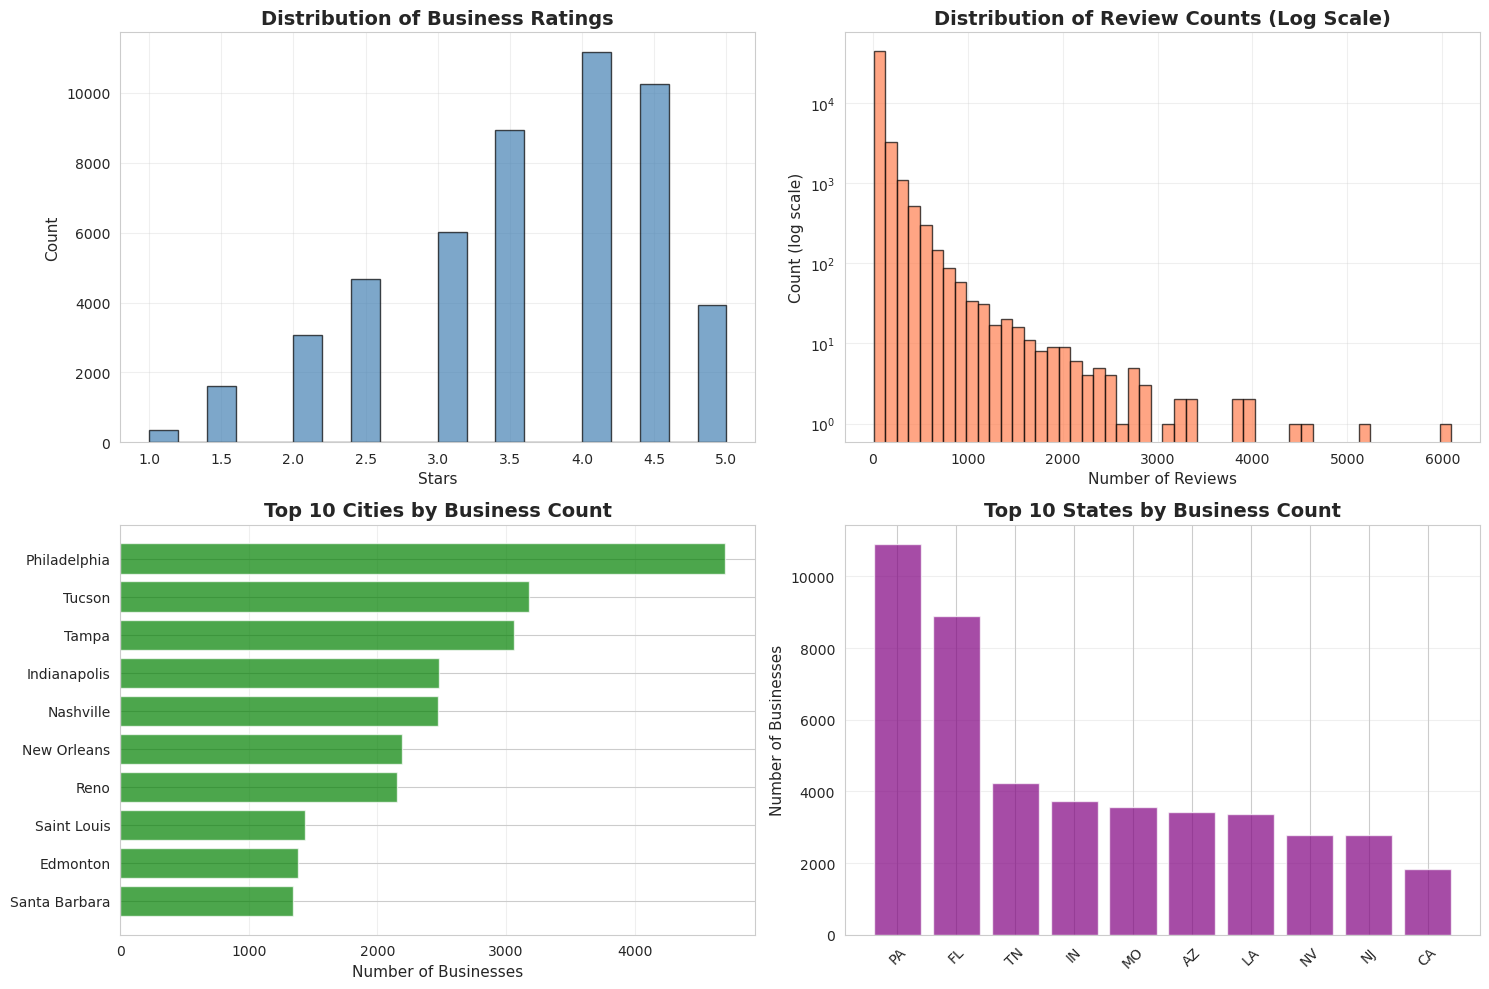


 Visualizations created successfully!
   Saved as: eda_business_overview.png

CATEGORY ANALYSIS

 Total unique categories: 1,217

🔝 Top 15 Categories:
    1. Restaurants                    - 19,206 businesses
    2. Food                           - 10,029 businesses
    3. Shopping                       - 7,386 businesses
    4. Beauty & Spas                  - 4,990 businesses
    5. Nightlife                      - 4,644 businesses
    6. Bars                           - 4,268 businesses
    7. Home Services                  - 4,045 businesses
    8. Event Planning & Services      - 3,868 businesses
    9. Automotive                     - 3,666 businesses
   10. Health & Medical               - 3,503 businesses
   11. Local Services                 - 3,384 businesses
   12. Sandwiches                     - 3,190 businesses
   13. American (Traditional)         - 3,183 businesses
   14. Pizza                          - 2,812 businesses
   15. Fast Food                      - 2,722 bu

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 10)

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Rating Distribution
axes[0, 0].hist(business_df['stars'], bins=20, edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 0].set_title('Distribution of Business Ratings', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Stars', fontsize=11)
axes[0, 0].set_ylabel('Count', fontsize=11)
axes[0, 0].grid(True, alpha=0.3)

# 2. Review Count Distribution (Log Scale)
axes[0, 1].hist(business_df['review_count'], bins=50, edgecolor='black', alpha=0.7, color='coral')
axes[0, 1].set_yscale('log')
axes[0, 1].set_title('Distribution of Review Counts (Log Scale)', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Number of Reviews', fontsize=11)
axes[0, 1].set_ylabel('Count (log scale)', fontsize=11)
axes[0, 1].grid(True, alpha=0.3)

# 3. Top 10 Cities
top_cities = business_df['city'].value_counts().head(10)
y_pos = range(len(top_cities))
axes[1, 0].barh(y_pos, top_cities.values, alpha=0.7, color='green')
axes[1, 0].set_yticks(y_pos)
axes[1, 0].set_yticklabels(top_cities.index)
axes[1, 0].set_title('Top 10 Cities by Business Count', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Number of Businesses', fontsize=11)
axes[1, 0].invert_yaxis()
axes[1, 0].grid(True, alpha=0.3, axis='x')

# 4. Top 10 States
top_states = business_df['state'].value_counts().head(10)
x_pos = range(len(top_states))
axes[1, 1].bar(x_pos, top_states.values, alpha=0.7, color='purple')
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels(top_states.index, rotation=45)
axes[1, 1].set_title('Top 10 States by Business Count', fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('Number of Businesses', fontsize=11)
axes[1, 1].grid(True, alpha=0.3, axis='y')

# Adjust layout and save
plt.tight_layout()
plt.savefig('eda_business_overview.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n Visualizations created successfully!")
print("   Saved as: eda_business_overview.png")

# Additional: Category analysis if categories exist
if 'categories' in business_df.columns:
    print("\n" + "="*80)
    print("CATEGORY ANALYSIS")
    print("="*80)
    
    # Extract individual categories
    all_categories = []
    for cats in business_df['categories'].dropna():
        if isinstance(cats, str):
            all_categories.extend([c.strip() for c in cats.split(',')])
    
    from collections import Counter
    category_counts = Counter(all_categories)
    
    print(f"\n Total unique categories: {len(category_counts):,}")
    print("\n🔝 Top 15 Categories:")
    for idx, (cat, count) in enumerate(category_counts.most_common(15), 1):
        print(f"   {idx:2d}. {cat:30s} - {count:,} businesses")

print("\n" + "="*80)
print(" Section 4 Complete - EDA")









---

## 5. Feature Engineering & Feature Store <a id='section-5'></a>

This section:
- Engineers features from raw data
- Creates parking-related features
- Stores features in SageMaker Feature Store
- Splits data into train/test/validation sets

**Key Features**:
- Parking availability indicators
- Review aggregations
- Business characteristics
- Target variable: High rating indicator (4+ stars)

### 5.1 Load Full Dataset from Athena

In [19]:
# Query to join business and review data
query = f"""
SELECT 
    b.business_id,
    b.name,
    b.city,
    b.state,
    b.stars as business_stars,
    b.review_count as business_review_count,
    b.categories,
    r.review_id,
    r.user_id,
    r.stars as review_stars,
    r.useful,
    r.funny,
    r.cool,
    r.text as review_text,
    r.date as review_date
FROM {ATHENA_DB}.business b
INNER JOIN {ATHENA_DB}.review r ON b.business_id = r.business_id
WHERE b.is_open = 1
    AND b.review_count >= 10
    AND r.stars IS NOT NULL
LIMIT 100000
"""

print("⏳ Executing query (this will take a few minutes)...")
df = pd.read_sql(query, conn)
print(f"\n Loaded {len(df):,} reviews from {df['business_id'].nunique():,} businesses")
print(f"   Date range: {df['review_date'].min()} to {df['review_date'].max()}")
print(f"   Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

# Display sample
print("\n Sample data:")
display(df.head())


⏳ Executing query (this will take a few minutes)...

 Loaded 100,000 reviews from 1,447 businesses
   Date range: 2005-03-12 18:37:40 to 2022-01-19 19:31:01
   Memory usage: 117.4 MB

 Sample data:


,business_id,name,city,state,business_stars,business_review_count,categories,review_id,user_id,review_stars,useful,funny,cool,review_text,review_date
0,vl40Oa75v42jvJsHwpCGKA,Maple Street Biscuit Company - Carrollwood,Tampa,FL,4.5,452,"Southern, Breakfast & Brunch, Comfort Food, Ve...",ILUkOqiOI4OAP66sFIK2wg,N0zPkywxRWcdwIdDydRjsg,5.0,2,0,1,When my friend recommended this place for our ...,2018-12-26 19:17:14
1,vl40Oa75v42jvJsHwpCGKA,Maple Street Biscuit Company - Carrollwood,Tampa,FL,4.5,452,"Southern, Breakfast & Brunch, Comfort Food, Ve...",2Ct-HcjBdMpyYVV7BIaj4A,3TU5m__ztl22NcL-Ch9baQ,5.0,0,0,0,We visited Maple Street on a Saturday during b...,2018-08-05 02:06:55
2,vl40Oa75v42jvJsHwpCGKA,Maple Street Biscuit Company - Carrollwood,Tampa,FL,4.5,452,"Southern, Breakfast & Brunch, Comfort Food, Ve...",58xXVof8-Jav_YF6vdCwJg,tLu96qF5wHajKL0YU_i5Fg,4.0,0,0,0,"They close after lunch, thankfully I was done ...",2019-04-21 23:58:15
3,vl40Oa75v42jvJsHwpCGKA,Maple Street Biscuit Company - Carrollwood,Tampa,FL,4.5,452,"Southern, Breakfast & Brunch, Comfort Food, Ve...",EK3p95v6N-vVFWwHbfGJ2A,jcVvrk1tWBOoGwbdLiUHow,5.0,0,0,0,My b/f and I visited here this past weekend fo...,2019-04-01 14:04:05
4,vl40Oa75v42jvJsHwpCGKA,Maple Street Biscuit Company - Carrollwood,Tampa,FL,4.5,452,"Southern, Breakfast & Brunch, Comfort Food, Ve...",xZsG5iSqG09rMWAG5xbAuA,awc2ZDTlv_UwVj-O0PDVLQ,5.0,0,0,0,Holy smokes! This place brings back memories o...,2019-08-10 18:38:04


### 5.2 Engineer Features

In [20]:
# Step 1: Extract Parking Information from Review Text
print("\n1️  Extracting parking information from review text...")

def extract_parking_features(text):
    """
    Extract parking-related features from review text.
    Returns a dict with parking indicators.
    """
    if pd.isna(text):
        return {
            'mentions_parking': 0,
            'parking_positive': 0,
            'parking_negative': 0,
            'parking_type_lot': 0,
            'parking_type_street': 0,
            'parking_type_garage': 0,
            'parking_type_valet': 0,
            'parking_free': 0,
            'parking_paid': 0
        }
    
    text_lower = text.lower()
    
    # Check if parking is mentioned
    parking_keywords = ['parking', 'park', 'parked']
    mentions_parking = int(any(keyword in text_lower for keyword in parking_keywords))
    
    # Positive parking indicators
    positive_keywords = [
        'easy parking', 'plenty of parking', 'ample parking',
        'free parking', 'good parking', 'great parking',
        'lots of parking', 'parking available', 'easy to park'
    ]
    parking_positive = int(any(keyword in text_lower for keyword in positive_keywords))
    
    # Negative parking indicators
    negative_keywords = [
        'no parking', 'parking nightmare', 'hard to park',
        'difficult parking', 'parking is terrible', 'parking sucks',
        'nowhere to park', 'parking is bad', 'limited parking',
        'parking is horrible', 'parking was awful'
    ]
    parking_negative = int(any(keyword in text_lower for keyword in negative_keywords))
    
    # Parking types
    parking_type_lot = int('parking lot' in text_lower or 'lot parking' in text_lower)
    parking_type_street = int('street parking' in text_lower or 'park on the street' in text_lower)
    parking_type_garage = int('parking garage' in text_lower or 'garage parking' in text_lower)
    parking_type_valet = int('valet' in text_lower)
    
    # Cost indicators
    parking_free = int('free parking' in text_lower or 'free park' in text_lower)
    parking_paid = int('paid parking' in text_lower or 'pay for parking' in text_lower or 'parking fee' in text_lower)
    
    return {
        'mentions_parking': mentions_parking,
        'parking_positive': parking_positive,
        'parking_negative': parking_negative,
        'parking_type_lot': parking_type_lot,
        'parking_type_street': parking_type_street,
        'parking_type_garage': parking_type_garage,
        'parking_type_valet': parking_type_valet,
        'parking_free': parking_free,
        'parking_paid': parking_paid
    }

# Apply parking extraction
parking_features = df['review_text'].apply(extract_parking_features)
parking_df = pd.DataFrame(parking_features.tolist())

# Add to main dataframe
for col in parking_df.columns:
    df[col] = parking_df[col]

print(f" Extracted parking features from {len(df):,} reviews")
print(f"\n   Parking Statistics:")
print(f"   - Reviews mentioning parking: {df['mentions_parking'].sum():,} ({df['mentions_parking'].mean()*100:.1f}%)")
print(f"   - Positive parking mentions: {df['parking_positive'].sum():,}")
print(f"   - Negative parking mentions: {df['parking_negative'].sum():,}")
print(f"   - Free parking mentions: {df['parking_free'].sum():,}")


# Step 2: Parse review date and create temporal features
print("\n2️  Creating temporal features...")

df['review_date'] = pd.to_datetime(df['review_date'])
df['review_year'] = df['review_date'].dt.year
df['review_month'] = df['review_date'].dt.month
df['review_day_of_week'] = df['review_date'].dt.dayofweek
df['review_quarter'] = df['review_date'].dt.quarter

print(" Created temporal features")


# Step 3: Create engagement score
print("\n3️  Creating engagement features...")

df['engagement_score'] = df['useful'] + df['funny'] + df['cool']
df['is_engaged'] = (df['engagement_score'] > 0).astype(int)

print(" Created engagement features")


# Step 4: Create target variable
print("\n4️  Creating target variable...")

df['is_highly_rated'] = (df['review_stars'] >= 4).astype(int)

print(f" Created target variable")
print(f"   - Highly rated (4+ stars): {df['is_highly_rated'].sum():,} ({df['is_highly_rated'].mean()*100:.1f}%)")
print(f"   - Not highly rated: {(1-df['is_highly_rated']).sum():,} ({(1-df['is_highly_rated']).mean()*100:.1f}%)")


# Step 5: Business-level aggregations
print("\n5️  Creating business-level aggregates...")

business_agg = df.groupby('business_id').agg({
    'review_stars': ['mean', 'std', 'count', 'min', 'max'],
    'engagement_score': ['mean', 'sum'],
    'is_highly_rated': 'mean',
    'mentions_parking': ['sum', 'mean'],
    'parking_positive': 'sum',
    'parking_negative': 'sum',
    'parking_type_lot': 'sum',
    'parking_type_street': 'sum',
    'parking_type_garage': 'sum',
    'parking_type_valet': 'sum',
    'parking_free': 'sum'
}).reset_index()

# Flatten column names
business_agg.columns = [
    'business_id',
    'avg_review_stars', 'std_review_stars', 'total_reviews', 'min_review_stars', 'max_review_stars',
    'avg_engagement', 'total_engagement',
    'pct_highly_rated',
    'total_parking_mentions', 'pct_reviews_mention_parking',
    'total_positive_parking', 'total_negative_parking',
    'total_lot_mentions', 'total_street_mentions', 'total_garage_mentions', 'total_valet_mentions',
    'total_free_parking_mentions'
]

# Create derived parking features
business_agg['has_parking_data'] = (business_agg['total_parking_mentions'] > 0).astype(int)
business_agg['parking_sentiment'] = (
    (business_agg['total_positive_parking'] - business_agg['total_negative_parking']) / 
    (business_agg['total_parking_mentions'] + 1)  # +1 to avoid division by zero
)

# Determine dominant parking type
business_agg['primary_parking_type'] = business_agg[
    ['total_lot_mentions', 'total_street_mentions', 'total_garage_mentions', 'total_valet_mentions']
].idxmax(axis=1).str.replace('total_', '').str.replace('_mentions', '')

print(f" Created business-level aggregates")
print(f"   - Unique businesses: {len(business_agg):,}")
print(f"   - Businesses with parking data: {business_agg['has_parking_data'].sum():,} ({business_agg['has_parking_data'].mean()*100:.1f}%)")

# Display sample
print("\n Sample business aggregates:")
display(business_agg.head())


# Step 6: Merge aggregates back to reviews
print("\n6️  Merging business aggregates back to review data...")

df = df.merge(business_agg, on='business_id', how='left', suffixes=('', '_agg'))

print(f" Merged aggregates - DataFrame now has {len(df.columns)} columns")


# Step 7: Handle categories
print("\n7️  Processing business categories...")

# Check if business is a restaurant
df['is_restaurant'] = df['categories'].fillna('').str.contains('Restaurant|Food', case=False, na=False).astype(int)

# Extract price range from categories (if present)
def extract_price_range(categories):
    if pd.isna(categories):
        return 2  # Default to medium price
    # Look for price indicators in categories
    if any(word in categories.lower() for word in ['$$$', 'expensive', 'upscale', 'fine dining']):
        return 4
    elif any(word in categories.lower() for word in ['$$', 'moderate']):
        return 3
    elif any(word in categories.lower() for word in ['$', 'cheap', 'budget', 'fast food']):
        return 1
    else:
        return 2  # Default

df['price_range_numeric'] = df['categories'].apply(extract_price_range)

print(f" Processed categories")
print(f"   - Restaurants: {df['is_restaurant'].sum():,} ({df['is_restaurant'].mean()*100:.1f}%)")


# Step 8: Create enhanced parking score
print("\n8️  Creating enhanced parking score...")

# Weighted parking score combining multiple factors
df['enhanced_parking_score'] = (
    df['parking_positive'] * 2 +           # Positive mention worth 2 points
    df['parking_negative'] * -2 +          # Negative mention -2 points
    df['parking_free'] * 1 +               # Free parking worth 1 point
    df['parking_type_lot'] * 0.5 +         # Lot parking worth 0.5
    df['parking_type_garage'] * 0.5 +      # Garage parking worth 0.5
    df['parking_type_valet'] * 0.3 +       # Valet worth 0.3
    df['parking_type_street'] * 0.2        # Street parking worth 0.2
)

# Normalize to 0-10 scale
df['enhanced_parking_score'] = (
    (df['enhanced_parking_score'] - df['enhanced_parking_score'].min()) / 
    (df['enhanced_parking_score'].max() - df['enhanced_parking_score'].min()) * 10
)

print(f" Created enhanced parking score")
print(f"   - Mean score: {df['enhanced_parking_score'].mean():.2f}")
print(f"   - Median score: {df['enhanced_parking_score'].median():.2f}")


# Display final feature summary
print("\n" + "="*80)
print("FEATURE ENGINEERING COMPLETE")
print("="*80)
print(f"\n Final Dataset Summary:")
print(f"   Total records: {len(df):,}")
print(f"   Total features: {len(df.columns)}")
print(f"   Unique businesses: {df['business_id'].nunique():,}")
print(f"   Unique users: {df['user_id'].nunique():,}")
print(f"\n Target Variable Distribution:")
print(f"   Highly rated (4+ stars): {df['is_highly_rated'].sum():,} ({df['is_highly_rated'].mean()*100:.1f}%)")
print(f"   Not highly rated: {(1-df['is_highly_rated']).sum():,} ({(1-df['is_highly_rated']).mean()*100:.1f}%)")
print(f"\n Parking Feature Coverage:")
print(f"   Reviews with parking mentions: {df['mentions_parking'].sum():,} ({df['mentions_parking'].mean()*100:.1f}%)")
print(f"   Businesses with parking data: {business_agg['has_parking_data'].sum():,}")


1️  Extracting parking information from review text...
 Extracted parking features from 100,000 reviews

   Parking Statistics:
   - Reviews mentioning parking: 5,306 (5.3%)
   - Positive parking mentions: 523
   - Negative parking mentions: 120
   - Free parking mentions: 140

2️  Creating temporal features...
 Created temporal features

3️  Creating engagement features...
 Created engagement features

4️  Creating target variable...
 Created target variable
   - Highly rated (4+ stars): 67,742 (67.7%)
   - Not highly rated: 32,258 (32.3%)

5️  Creating business-level aggregates...
 Created business-level aggregates
   - Unique businesses: 1,447
   - Businesses with parking data: 885 (61.2%)

 Sample business aggregates:


,business_id,avg_review_stars,std_review_stars,total_reviews,min_review_stars,max_review_stars,avg_engagement,total_engagement,pct_highly_rated,total_parking_mentions,...,total_positive_parking,total_negative_parking,total_lot_mentions,total_street_mentions,total_garage_mentions,total_valet_mentions,total_free_parking_mentions,has_parking_data,parking_sentiment,primary_parking_type
0,--0iUa4sNDFiZFrAdIWhZQ,3.214286,1.368805,14,1.0,5.0,2.285714,32,0.500000,1,...,0,1,0,0,0,0,0,1,-0.5,lot
1,-6jVwUuXC1-dyr2YRCEU6Q,3.802632,1.376515,228,1.0,5.0,1.657895,378,0.697368,0,...,0,0,0,0,0,0,0,0,0.0,lot
2,-8jIGHKz1-Tnv2X85kxbvQ,3.304348,1.717154,23,1.0,5.0,1.130435,26,0.565217,0,...,0,0,0,0,0,0,0,0,0.0,lot
3,-EXQaHaB8zNpmcCQlfXVNw,4.100000,1.663330,10,1.0,5.0,1.800000,18,0.800000,0,...,0,0,0,0,0,0,0,0,0.0,lot
4,-FHupA0HcLv3uCGAgK7khQ,4.380952,1.286940,42,1.0,5.0,0.880952,37,0.833333,0,...,0,0,0,0,0,0,0,0,0.0,lot



6️  Merging business aggregates back to review data...
 Merged aggregates - DataFrame now has 51 columns

7️  Processing business categories...
 Processed categories
   - Restaurants: 73,913 (73.9%)

8️  Creating enhanced parking score...
 Created enhanced parking score
   - Mean score: 3.54
   - Median score: 3.51

FEATURE ENGINEERING COMPLETE

 Final Dataset Summary:
   Total records: 100,000
   Total features: 54
   Unique businesses: 1,447
   Unique users: 82,763

 Target Variable Distribution:
   Highly rated (4+ stars): 67,742 (67.7%)
   Not highly rated: 32,258 (32.3%)

 Parking Feature Coverage:
   Reviews with parking mentions: 5,306 (5.3%)
   Businesses with parking data: 885


### 5.3 Prepare Data for Feature Store

In [21]:
# Select features for Feature Store
feature_columns = [
    'review_id',  # Primary key
    'business_id',
    'user_id',
    # Parking features (extracted from review text)
    'mentions_parking',
    'parking_positive',
    'parking_negative',
    'parking_type_lot',
    'parking_type_street',
    'parking_type_garage',
    'parking_type_valet',
    'parking_free',
    'parking_paid',
    'enhanced_parking_score',
    # Business features (from aggregates)
    'business_stars',
    'business_review_count',
    'avg_review_stars',
    'std_review_stars',
    'total_reviews',
    'avg_engagement',
    'pct_highly_rated',
    'has_parking_data',
    'parking_sentiment',
    # Review features
    'review_stars',
    'useful',
    'funny',
    'cool',
    'engagement_score',
    'is_engaged',
    'review_year',
    'review_month',
    'review_quarter',
    # Business type
    'is_restaurant',
    'price_range_numeric',
    # Target
    'is_highly_rated'
]

# Create feature store dataframe
print("\n1️  Selecting features...")
fs_df = df[feature_columns].copy()

# Add event time (required by Feature Store)
print("\n2️  Adding event time...")
fs_df['event_time'] = pd.Timestamp.now().isoformat()

# Remove any remaining nulls
print("\n3️  Handling missing values...")
initial_count = len(fs_df)
fs_df = fs_df.dropna()
print(f"   Dropped {initial_count - len(fs_df):,} rows with missing values")
print(f"   Remaining: {len(fs_df):,} rows")

# Add data split column for train/test/validation
print("\n4️  Creating train/test/validation splits...")
np.random.seed(42)
fs_df['split'] = np.random.choice(
    ['train', 'validation', 'test', 'production'],
    size=len(fs_df),
    p=[0.4, 0.1, 0.1, 0.4]  # 40% train, 10% val, 10% test, 40% production
)

print("\n Data split distribution:")
print(fs_df['split'].value_counts().sort_index())
print(f"\n   Train:      {len(fs_df[fs_df['split']=='train']):,} rows")
print(f"   Validation: {len(fs_df[fs_df['split']=='validation']):,} rows")
print(f"   Test:       {len(fs_df[fs_df['split']=='test']):,} rows")
print(f"   Production: {len(fs_df[fs_df['split']=='production']):,} rows")

# Display sample
print("\n Feature Store DataFrame sample:")
display(fs_df.head())

print("\n" + "="*80)
print(" SECTION 5 COMPLETE")
print("="*80)
print(f"\nFeature Store DataFrame:")
print(f"  - Total records: {len(fs_df):,}")
print(f"  - Total features: {len(feature_columns)}")
print(f"  - Memory usage: {fs_df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")
print(f"\n Ready to ingest into SageMaker Feature Store")


1️  Selecting features...

2️  Adding event time...

3️  Handling missing values...
   Dropped 0 rows with missing values
   Remaining: 100,000 rows

4️  Creating train/test/validation splits...

 Data split distribution:
split
production    40005
test          10061
train         39985
validation     9949
Name: count, dtype: int64

   Train:      39,985 rows
   Validation: 9,949 rows
   Test:       10,061 rows
   Production: 40,005 rows

 Feature Store DataFrame sample:


,review_id,business_id,user_id,mentions_parking,parking_positive,parking_negative,parking_type_lot,parking_type_street,parking_type_garage,parking_type_valet,...,engagement_score,is_engaged,review_year,review_month,review_quarter,is_restaurant,price_range_numeric,is_highly_rated,event_time,split
0,ILUkOqiOI4OAP66sFIK2wg,vl40Oa75v42jvJsHwpCGKA,N0zPkywxRWcdwIdDydRjsg,0,0,0,0,0,0,0,...,3,1,2018,12,4,1,2,1,2026-02-07T03:31:09.858709,train
1,2Ct-HcjBdMpyYVV7BIaj4A,vl40Oa75v42jvJsHwpCGKA,3TU5m__ztl22NcL-Ch9baQ,0,0,0,0,0,0,0,...,0,0,2018,8,3,1,2,1,2026-02-07T03:31:09.858709,production
2,58xXVof8-Jav_YF6vdCwJg,vl40Oa75v42jvJsHwpCGKA,tLu96qF5wHajKL0YU_i5Fg,0,0,0,0,0,0,0,...,0,0,2019,4,2,1,2,1,2026-02-07T03:31:09.858709,production
3,EK3p95v6N-vVFWwHbfGJ2A,vl40Oa75v42jvJsHwpCGKA,jcVvrk1tWBOoGwbdLiUHow,0,0,0,0,0,0,0,...,0,0,2019,4,2,1,2,1,2026-02-07T03:31:09.858709,test
4,xZsG5iSqG09rMWAG5xbAuA,vl40Oa75v42jvJsHwpCGKA,awc2ZDTlv_UwVj-O0PDVLQ,0,0,0,0,0,0,0,...,0,0,2019,8,3,1,2,1,2026-02-07T03:31:09.858709,train



 SECTION 5 COMPLETE

Feature Store DataFrame:
  - Total records: 100,000
  - Total features: 34
  - Memory usage: 55.4 MB

 Ready to ingest into SageMaker Feature Store


### 5.4 Create SageMaker Feature Store

Store the engineered features in SageMaker Feature Store for:
- Versioned feature access
- Online and offline feature serving
- Feature reuse across models

In [22]:
# Feature store configuration using Account ID
feature_group_name = f"venuesignal-features-{account_id}"
feature_store_bucket = f"s3://{FEATURE_BUCKET}/{FEATURE_PREFIX}"

print(f"Feature Group Name: {feature_group_name}")
print(f"Offline Store: {feature_store_bucket}")

# Create feature group
feature_group = FeatureGroup(
    name=feature_group_name,
    sagemaker_session=sagemaker_session
)

# Load feature definitions from dataframe
feature_group.load_feature_definitions(data_frame=fs_df)

print(f"\n Feature group configured with {len(fs_df.columns)} features")

Feature Group Name: venuesignal-features-356396930368
Offline Store: s3://yelp-aai540-group6-features-356396930368/feature-store/

 Feature group configured with 36 features


In [23]:
# Create the feature group (if it doesn't exist)
try:
    feature_group.create(
        s3_uri=feature_store_bucket,
        record_identifier_name="review_id",
        event_time_feature_name="event_time",
        role_arn=role,
        enable_online_store=False  # Only offline store for this project
    )
    print(f" Created feature group: {feature_group_name}")
    print("   Waiting for creation to complete (this may take a few minutes)...")
    
    # Wait for feature group to be created
    import time
    while True:
        status = feature_group.describe()['FeatureGroupStatus']
        if status == 'Created':
            print(" Feature group is ready!")
            break
        elif status == 'CreateFailed':
            print(" Feature group creation failed")
            break
        print(f"   Status: {status}...")
        time.sleep(30)
        
except Exception as e:
    if 'ResourceInUse' in str(e):
        print(f" Feature group '{feature_group_name}' already exists")
    else:
        print(f" Error creating feature group: {e}")

 Feature group 'venuesignal-features-356396930368' already exists


In [24]:
# Ingest features into feature store
from datetime import datetime

print("Fixing event_time format...")
current_time = datetime.utcnow().strftime('%Y-%m-%dT%H:%M:%SZ')
fs_df['event_time'] = current_time  # Use same timestamp for all rows
fs_df['event_time'] = fs_df['event_time'].astype(str)  # Ensure string type
print(f" Fixed event_time: {current_time}")

# Now ingest in small batches
print(f"\nIngesting {len(fs_df):,} records...")
batch_size = 1000
successful = 0

for i in range(0, len(fs_df), batch_size):
    batch = fs_df.iloc[i:i+batch_size].copy()
    batch['event_time'] = current_time  # Ensure format
    
    try:
        feature_group.ingest(data_frame=batch, max_workers=2, wait=True)
        successful += len(batch)
        print(f"   Batch {i//batch_size + 1}: {successful:,} total records", end='\r')
    except Exception as e:
        if 'already' in str(e).lower():
            print(f"    Batch {i//batch_size + 1}: Already ingested")
        else:
            print(f"   Batch {i//batch_size + 1}: {str(e)[:80]}")

print(f"\n\n Ingestion complete! {successful:,} records ingested")

Fixing event_time format...
 Fixed event_time: 2026-02-07T03:31:10Z

Ingesting 100,000 records...
   Batch 100: 100,000 total records

 Ingestion complete! 100,000 records ingested


### 5.5 Export Features for Training

Export features from Feature Store to S3 for model training.

In [25]:
# Step 1: Split the data
print("\n1️  Splitting data...")
train_df = fs_df[fs_df['split'] == 'train'].drop(columns=['event_time', 'split'])
validation_df = fs_df[fs_df['split'] == 'validation'].drop(columns=['event_time', 'split'])
test_df = fs_df[fs_df['split'] == 'test'].drop(columns=['event_time', 'split'])
production_df = fs_df[fs_df['split'] == 'production'].drop(columns=['event_time', 'split'])

print(f"    Train:      {len(train_df):,} records")
print(f"    Validation: {len(validation_df):,} records")
print(f"    Test:       {len(test_df):,} records")
print(f"    Production: {len(production_df):,} records")

# Step 2: Save locally (SIMPLE path - no complex directories!)
print("\n2️  Saving to local files...")

# Just use /tmp directly - simple and always works!
train_df.to_csv('/tmp/train.csv', index=False)
print("    /tmp/train.csv")

validation_df.to_csv('/tmp/validation.csv', index=False)
print("    /tmp/validation.csv")

test_df.to_csv('/tmp/test.csv', index=False)
print("    /tmp/test.csv")

production_df.to_csv('/tmp/production.csv', index=False)
print("    /tmp/production.csv")

# Step 3: Upload to S3
print("\n3️  Uploading to S3...")

# Define S3 paths
train_data_path = f"s3://{FEATURE_BUCKET}/training-data/train.csv"
validation_data_path = f"s3://{FEATURE_BUCKET}/training-data/validation.csv"
test_data_path = f"s3://{FEATURE_BUCKET}/training-data/test.csv"
production_data_path = f"s3://{FEATURE_BUCKET}/training-data/production.csv"

# Upload each file
uploads = [
    ('/tmp/train.csv', train_data_path, 'train.csv'),
    ('/tmp/validation.csv', validation_data_path, 'validation.csv'),
    ('/tmp/test.csv', test_data_path, 'test.csv'),
    ('/tmp/production.csv', production_data_path, 'production.csv')
]

for local_file, s3_uri, display_name in uploads:
    bucket = s3_uri.split('/')[2]
    key = '/'.join(s3_uri.split('/')[3:])
    
    try:
        s3_client.upload_file(local_file, bucket, key)
        print(f"    {display_name} → {s3_uri}")
    except Exception as e:
        print(f"    {display_name} failed: {e}")

# Step 4: Store variables
print("\n4️  Storing variables...")
%store train_data_path
%store validation_data_path
%store test_data_path
%store production_data_path

print("    Variables stored")

# Step 5: Summary
print("\n" + "="*80)
print(" SECTION 5.7 COMPLETE - DATA EXPORTED!")
print("="*80)

print(f"\n S3 Locations:")
print(f"   Train:      {train_data_path}")
print(f"   Validation: {validation_data_path}")
print(f"   Test:       {test_data_path}")
print(f"   Production: {production_data_path}")

print(f"  Local Files (temporary):")
for filename in ['train.csv', 'validation.csv', 'test.csv', 'production.csv']:
    filepath = f'/tmp/{filename}'
    if os.path.exists(filepath):
        size_mb = os.path.getsize(filepath) / (1024 * 1024)
        print(f"   {filepath:30s} - {size_mb:6.2f} MB")

print("\n" + "="*80)
print(" SECTION 5 COMPLETE!")
print("="*80)
print("\n Summary:")
print(f"    Features engineered from review text")
print(f"    {len(fs_df):,} total records processed")
print(f"    Training data split and exported")
print(f"    All data in S3 and ready for model training")


1️  Splitting data...
    Train:      39,985 records
    Validation: 9,949 records
    Test:       10,061 records
    Production: 40,005 records

2️  Saving to local files...
    /tmp/train.csv
    /tmp/validation.csv
    /tmp/test.csv
    /tmp/production.csv

3️  Uploading to S3...
    train.csv → s3://yelp-aai540-group6-features-356396930368/training-data/train.csv
    validation.csv → s3://yelp-aai540-group6-features-356396930368/training-data/validation.csv
    test.csv → s3://yelp-aai540-group6-features-356396930368/training-data/test.csv
    production.csv → s3://yelp-aai540-group6-features-356396930368/training-data/production.csv

4️  Storing variables...
Stored 'train_data_path' (str)
Stored 'validation_data_path' (str)
Stored 'test_data_path' (str)
Stored 'production_data_path' (str)
    Variables stored

 SECTION 5.7 COMPLETE - DATA EXPORTED!

 S3 Locations:
   Train:      s3://yelp-aai540-group6-features-356396930368/training-data/train.csv
   Validation: s3://yelp-aai540-

---

## 6. Model Training <a id='section-6'></a>

This section trains and evaluates multiple models:

1. **Baseline Model #1**: Simple heuristic (business average rating)
2. **Baseline Model #2**: Linear regression with key features
3. **XGBoost Model**: Gradient boosted trees for classification

**Goal**: Predict whether a review will be highly rated (4+ stars) based on business characteristics, especially parking availability.

In [17]:
# Define S3 paths
train_data_path = f"s3://{FEATURE_BUCKET}/training-data/train.csv"
validation_data_path = f"s3://{FEATURE_BUCKET}/training-data/validation.csv"
test_data_path = f"s3://{FEATURE_BUCKET}/training-data/test.csv"
production_data_path = f"s3://{FEATURE_BUCKET}/training-data/production.csv"

### 6.1 Load Training Data

In [33]:

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    mean_squared_error, mean_absolute_error, r2_score
)
import numpy as np
import pandas as pd

# Load training data
print("\n1️  Loading training data...")
train_df = pd.read_csv(train_data_path)
validation_df = pd.read_csv(validation_data_path)
test_df = pd.read_csv(test_data_path)

print(f"   Training:   {len(train_df):,} records")
print(f"   Validation: {len(validation_df):,} records")
print(f"   Test:       {len(test_df):,} records")

# Separate features and targets
print("\n2️  Preparing features and targets...")

# Classification target (binary)
y_train_class = train_df['is_highly_rated']
y_val_class = validation_df['is_highly_rated']
y_test_class = test_df['is_highly_rated']

# Regression target (actual stars)
y_train_stars = train_df['review_stars']
y_val_stars = validation_df['review_stars']
y_test_stars = test_df['review_stars']

print(f"\n   Classification target distribution:")
print(f"   - Highly rated (1): {y_train_class.sum():,} ({y_train_class.mean()*100:.1f}%)")
print(f"   - Not highly rated (0): {(1-y_train_class).sum():,} ({(1-y_train_class.mean())*100:.1f}%)")

print(f"\n   Star rating distribution:")
print(f"   - Mean: {y_train_stars.mean():.2f}")
print(f"   - Std:  {y_train_stars.std():.2f}")
print(f"   - Range: {y_train_stars.min():.0f} - {y_train_stars.max():.0f}")

def evaluate_model_comprehensive(y_true_class, y_pred_class, y_true_stars, y_pred_stars, 
                                   y_pred_proba=None, dataset_name="Dataset"):
    """
    Comprehensive evaluation with both classification and regression metrics.
    
    Parameters:
    - y_true_class: True binary labels (0/1)
    - y_pred_class: Predicted binary labels (0/1)
    - y_true_stars: True star ratings (1-5)
    - y_pred_stars: Predicted star ratings (1-5)
    - y_pred_proba: Predicted probabilities (optional, for ROC-AUC)
    - dataset_name: Name for display
    """
    results = {}
    
    # Classification Metrics
    results['accuracy'] = accuracy_score(y_true_class, y_pred_class)
    results['precision'] = precision_score(y_true_class, y_pred_class, zero_division=0)
    results['recall'] = recall_score(y_true_class, y_pred_class, zero_division=0)
    results['f1'] = f1_score(y_true_class, y_pred_class, zero_division=0)
    
    if y_pred_proba is not None:
        results['roc_auc'] = roc_auc_score(y_true_class, y_pred_proba)
    else:
        results['roc_auc'] = None
    
    # Regression Metrics
    results['mse'] = mean_squared_error(y_true_stars, y_pred_stars)
    results['rmse'] = np.sqrt(results['mse'])
    results['mae'] = mean_absolute_error(y_true_stars, y_pred_stars)
    results['r2'] = r2_score(y_true_stars, y_pred_stars)
    
    # Custom Metrics: Within X stars
    abs_error = np.abs(y_true_stars - y_pred_stars)
    results['within_0.5_stars'] = (abs_error <= 0.5).mean()
    results['within_1.0_stars'] = (abs_error <= 1.0).mean()
    
    return results


def print_results(results, model_name, dataset_name):
    """Pretty print evaluation results."""
    print(f"\n{'='*80}")
    print(f"{model_name} - {dataset_name}")
    print(f"{'='*80}")
    
    print(f"\n Classification Metrics (Binary: Highly Rated vs Not):")
    print(f"   Accuracy:  {results['accuracy']:.4f}")
    print(f"   Precision: {results['precision']:.4f}")
    print(f"   Recall:    {results['recall']:.4f}")
    print(f"   F1-Score:  {results['f1']:.4f}")
    if results['roc_auc'] is not None:
        print(f"   ROC-AUC:   {results['roc_auc']:.4f}")
    
    print(f"\n Regression Metrics (Star Rating Prediction):")
    print(f"   MSE:       {results['mse']:.4f}")
    print(f"   RMSE:      {results['rmse']:.4f}")
    print(f"   MAE:       {results['mae']:.4f}")
    print(f"   R²:        {results['r2']:.4f}")
    
    print(f"\n Accuracy Metrics (Star Prediction):")
    print(f"   Within 0.5 stars: {results['within_0.5_stars']*100:.2f}%")
    print(f"   Within 1.0 stars: {results['within_1.0_stars']*100:.2f}%")




1️  Loading training data...
   Training:   39,985 records
   Validation: 9,949 records
   Test:       10,061 records

2️  Preparing features and targets...

   Classification target distribution:
   - Highly rated (1): 27,127 (67.8%)
   - Not highly rated (0): 12,858 (32.2%)

   Star rating distribution:
   - Mean: 3.77
   - Std:  1.47
   - Range: 1 - 5


### 6.2 Baseline Model #1: Simple Heuristic

In [34]:
print("\n" + "="*80)
print("BASELINE MODEL #1: Simple Heuristic")
print("="*80)
print("Approach: Predict highly_rated if avg_review_stars >= 4.0")

# Classification predictions
baseline1_pred_class_train = (train_df['avg_review_stars'] >= 4.0).astype(int)
baseline1_pred_class_val = (validation_df['avg_review_stars'] >= 4.0).astype(int)
baseline1_pred_class_test = (test_df['avg_review_stars'] >= 4.0).astype(int)

# Star predictions (use average directly)
baseline1_pred_stars_train = train_df['avg_review_stars']
baseline1_pred_stars_val = validation_df['avg_review_stars']
baseline1_pred_stars_test = test_df['avg_review_stars']

# Evaluate
baseline1_results_train = evaluate_model_comprehensive(
    y_train_class, baseline1_pred_class_train,
    y_train_stars, baseline1_pred_stars_train,
    y_pred_proba=None, dataset_name="Training"
)

baseline1_results_val = evaluate_model_comprehensive(
    y_val_class, baseline1_pred_class_val,
    y_val_stars, baseline1_pred_stars_val,
    y_pred_proba=None, dataset_name="Validation"
)

baseline1_results_test = evaluate_model_comprehensive(
    y_test_class, baseline1_pred_class_test,
    y_test_stars, baseline1_pred_stars_test,
    y_pred_proba=None, dataset_name="Test"
)

print_results(baseline1_results_train, "Baseline #1: Heuristic", "Training Set")
print_results(baseline1_results_val, "Baseline #1: Heuristic", "Validation Set")
print_results(baseline1_results_test, "Baseline #1: Heuristic", "Test Set")


BASELINE MODEL #1: Simple Heuristic
Approach: Predict highly_rated if avg_review_stars >= 4.0

Baseline #1: Heuristic - Training Set

 Classification Metrics (Binary: Highly Rated vs Not):
   Accuracy:  0.6321
   Precision: 0.8446
   Recall:    0.5610
   F1-Score:  0.6742

 Regression Metrics (Star Rating Prediction):
   MSE:       1.6397
   RMSE:      1.2805
   MAE:       1.0171
   R²:        0.2423

 Accuracy Metrics (Star Prediction):
   Within 0.5 stars: 29.34%
   Within 1.0 stars: 59.39%

Baseline #1: Heuristic - Validation Set

 Classification Metrics (Binary: Highly Rated vs Not):
   Accuracy:  0.6324
   Precision: 0.8547
   Recall:    0.5519
   F1-Score:  0.6707

 Regression Metrics (Star Rating Prediction):
   MSE:       1.5836
   RMSE:      1.2584
   MAE:       1.0041
   R²:        0.2574

 Accuracy Metrics (Star Prediction):
   Within 0.5 stars: 28.74%
   Within 1.0 stars: 59.51%

Baseline #1: Heuristic - Test Set

 Classification Metrics (Binary: Highly Rated vs Not):
   A

### 6.3 Baseline Model #2: Linear Regression

In [36]:

# Select features
baseline2_features = [
    'avg_review_stars',
    'enhanced_parking_score',
    'business_review_count'
]

print(f"Features: {', '.join(baseline2_features)}")

# Prepare feature matrices
X_train = train_df[baseline2_features].fillna(0)
X_val = validation_df[baseline2_features].fillna(0)
X_test = test_df[baseline2_features].fillna(0)

print(f"\n⏳ Training logistic regression...")
baseline2_model = LogisticRegression(random_state=42, max_iter=1000)
baseline2_model.fit(X_train, y_train_class)
print(" Model trained!")

# Classification predictions
baseline2_pred_class_train = baseline2_model.predict(X_train)
baseline2_pred_class_val = baseline2_model.predict(X_val)
baseline2_pred_class_test = baseline2_model.predict(X_test)

# Probabilities
baseline2_prob_train = baseline2_model.predict_proba(X_train)[:, 1]
baseline2_prob_val = baseline2_model.predict_proba(X_val)[:, 1]
baseline2_prob_test = baseline2_model.predict_proba(X_test)[:, 1]

# Convert probabilities to star predictions (1-5 scale)
# Probability 0-1 maps to stars 1-5
def prob_to_stars(prob):
    """Convert probability to star rating (1-5 scale)."""
    return 1 + (prob * 4)  # Maps 0->1, 0.5->3, 1->5

baseline2_pred_stars_train = prob_to_stars(baseline2_prob_train)
baseline2_pred_stars_val = prob_to_stars(baseline2_prob_val)
baseline2_pred_stars_test = prob_to_stars(baseline2_prob_test)

# Evaluate
baseline2_results_train = evaluate_model_comprehensive(
    y_train_class, baseline2_pred_class_train,
    y_train_stars, baseline2_pred_stars_train,
    y_pred_proba=baseline2_prob_train, dataset_name="Training"
)

baseline2_results_val = evaluate_model_comprehensive(
    y_val_class, baseline2_pred_class_val,
    y_val_stars, baseline2_pred_stars_val,
    y_pred_proba=baseline2_prob_val, dataset_name="Validation"
)

baseline2_results_test = evaluate_model_comprehensive(
    y_test_class, baseline2_pred_class_test,
    y_test_stars, baseline2_pred_stars_test,
    y_pred_proba=baseline2_prob_test, dataset_name="Test"
)

print_results(baseline2_results_train, "Baseline #2: Logistic Regression", "Training Set")
print_results(baseline2_results_val, "Baseline #2: Logistic Regression", "Validation Set")
print_results(baseline2_results_test, "Baseline #2: Logistic Regression", "Test Set")

# Feature importance
print(f"\n Feature Importance (Coefficients):")
for feature, coef in zip(baseline2_features, baseline2_model.coef_[0]):
    print(f"   {feature:30s}: {coef:8.4f}")




Features: avg_review_stars, enhanced_parking_score, business_review_count

⏳ Training logistic regression...
 Model trained!

Baseline #2: Logistic Regression - Training Set

 Classification Metrics (Binary: Highly Rated vs Not):
   Accuracy:  0.7371
   Precision: 0.7545
   Recall:    0.9078
   F1-Score:  0.8241
   ROC-AUC:   0.7539

 Regression Metrics (Star Rating Prediction):
   MSE:       1.6604
   RMSE:      1.2886
   MAE:       1.0226
   R²:        0.2327

 Accuracy Metrics (Star Prediction):
   Within 0.5 stars: 28.47%
   Within 1.0 stars: 61.08%

Baseline #2: Logistic Regression - Validation Set

 Classification Metrics (Binary: Highly Rated vs Not):
   Accuracy:  0.7430
   Precision: 0.7584
   Recall:    0.9114
   F1-Score:  0.8279
   ROC-AUC:   0.7613

 Regression Metrics (Star Rating Prediction):
   MSE:       1.5988
   RMSE:      1.2644
   MAE:       1.0079
   R²:        0.2503

 Accuracy Metrics (Star Prediction):
   Within 0.5 stars: 28.35%
   Within 1.0 stars: 61.31%

Ba

In [39]:

# =============================================================================
# COMPREHENSIVE MODEL COMPARISON
# =============================================================================

print("\n" + "="*80)
print("MODEL COMPARISON - VALIDATION SET")
print("="*80)

# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Metric': [
        'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC',
        'MSE', 'RMSE', 'MAE', 'R²',
        'Within 0.5★', 'Within 1.0★'
    ],
    'Baseline #1 (Heuristic)': [
        baseline1_results_val['accuracy'],
        baseline1_results_val['precision'],
        baseline1_results_val['recall'],
        baseline1_results_val['f1'],
        baseline1_results_val['roc_auc'] if baseline1_results_val['roc_auc'] else 0,
        baseline1_results_val['mse'],
        baseline1_results_val['rmse'],
        baseline1_results_val['mae'],
        baseline1_results_val['r2'],
        baseline1_results_val['within_0.5_stars'],
        baseline1_results_val['within_1.0_stars']
    ],
    'Baseline #2 (LogReg)': [
        baseline2_results_val['accuracy'],
        baseline2_results_val['precision'],
        baseline2_results_val['recall'],
        baseline2_results_val['f1'],
        baseline2_results_val['roc_auc'],
        baseline2_results_val['mse'],
        baseline2_results_val['rmse'],
        baseline2_results_val['mae'],
        baseline2_results_val['r2'],
        baseline2_results_val['within_0.5_stars'],
        baseline2_results_val['within_1.0_stars']
    ]
})

print("\n Validation Set Performance:")
print(comparison_df.to_string(index=False))

# Highlight best scores
print("\n Best Scores (Validation Set):")
print("\nClassification Metrics:")
print(f"   Best Accuracy:  {max(baseline1_results_val['accuracy'], baseline2_results_val['accuracy']):.4f}")
print(f"   Best F1-Score:  {max(baseline1_results_val['f1'], baseline2_results_val['f1']):.4f}")

print("\nRegression Metrics:")
print(f"   Best RMSE:      {min(baseline1_results_val['rmse'], baseline2_results_val['rmse']):.4f}")
print(f"   Best R²:        {max(baseline1_results_val['r2'], baseline2_results_val['r2']):.4f}")

print("\nPrediction Accuracy:")
print(f"   Best Within 0.5★: {max(baseline1_results_val['within_0.5_stars'], baseline2_results_val['within_0.5_stars'])*100:.2f}%")
print(f"   Best Within 1.0★: {max(baseline1_results_val['within_1.0_stars'], baseline2_results_val['within_1.0_stars'])*100:.2f}%")


# =============================================================================
# STORE RESULTS
# =============================================================================

# Store for later comparison with XGBoost
baseline_results = {
    'baseline1': {
        'train': baseline1_results_train,
        'val': baseline1_results_val,
        'test': baseline1_results_test
    },
    'baseline2': {
        'train': baseline2_results_train,
        'val': baseline2_results_val,
        'test': baseline2_results_test
    }
}

%store baseline_results
%store baseline2_features


MODEL COMPARISON - VALIDATION SET

 Validation Set Performance:
     Metric  Baseline #1 (Heuristic)  Baseline #2 (LogReg)
   Accuracy                 0.632425              0.742989
  Precision                 0.854717              0.758417
     Recall                 0.551867              0.911381
   F1-Score                 0.670689              0.827893
    ROC-AUC                 0.000000              0.761317
        MSE                 1.583585              1.598776
       RMSE                 1.258406              1.264427
        MAE                 1.004122              1.007937
         R²                 0.257427              0.250304
Within 0.5★                 0.287366              0.283546
Within 1.0★                 0.595135              0.613127

 Best Scores (Validation Set):

Classification Metrics:
   Best Accuracy:  0.7430
   Best F1-Score:  0.8279

Regression Metrics:
   Best RMSE:      1.2584
   Best R²:        0.2574

Prediction Accuracy:
   Best Within 0.5★: 28

In [ ]:
    'review_id',  # Primary key
    'business_id',
    'user_id',
    # Parking features (extracted from review text)
    'mentions_parking',
    'parking_positive',
    'parking_negative',
    'parking_type_lot',
    'parking_type_street',
    'parking_type_garage',
    'parking_type_valet',
    'parking_free',
    'parking_paid',
    'enhanced_parking_score',
    # Business features (from aggregates)
    'business_stars',
    'business_review_count',
    'avg_review_stars',
    'std_review_stars',
    'total_reviews',
    'avg_engagement',
    'pct_highly_rated',
    'has_parking_data',
    'parking_sentiment',
    # Review features
    'review_stars',
    'useful',
    'funny',
    'cool',
    'engagement_score',
    'is_engaged',
    'review_year',
    'review_month',
    'review_quarter',
    # Business type
    'is_restaurant',
    'price_range_numeric',
    # Target
    'is_highly_rated'

### 6.4 XGBoost Model Training

In [41]:

import sagemaker
from sagemaker import get_execution_role
from sagemaker.inputs import TrainingInput
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer
import boto3
import time

# Configuration
print("\n1️  Configuring XGBoost training...")

# Select features for XGBoost (more features than baseline)
xgb_features = [
    # Business features
    'avg_review_stars',
    'std_review_stars',
    'business_review_count',
    'pct_highly_rated',
    # Parking features
    'enhanced_parking_score',
    'parking_positive',
    'parking_negative',
    'parking_sentiment',
    'has_parking_data',
    # Review engagement
    'avg_engagement',
    # Business attributes
    'is_restaurant',
    'price_range_numeric'
]

print(f"   Selected {len(xgb_features)} features for XGBoost")
print(f"\n   Features:")
for i, feat in enumerate(xgb_features, 1):
    print(f"   {i:2d}. {feat}")

# Prepare data for XGBoost (target must be first column, no header)
print("\n2️  Preparing data for XGBoost format...")

def prepare_xgb_data(df, features, target='is_highly_rated'):
    """Prepare data in XGBoost format: target first, no header."""
    # Select features and fill missing values
    X = df[features].fillna(0)
    y = df[target]
    
    # Combine with target first
    xgb_data = pd.concat([y, X], axis=1)
    
    return xgb_data

# Prepare datasets
train_xgb = prepare_xgb_data(train_df, xgb_features)
val_xgb = prepare_xgb_data(validation_df, xgb_features)

print(f"   Training data shape: {train_xgb.shape}")
print(f"   Validation data shape: {val_xgb.shape}")

# Save locally
print("\n3️  Saving XGBoost-formatted data...")
train_xgb.to_csv('/tmp/train_xgb.csv', index=False, header=False)
val_xgb.to_csv('/tmp/val_xgb.csv', index=False, header=False)
print("    Data saved in XGBoost format")

# Upload to S3
print("\n4️  Uploading to S3...")
xgb_train_path = f"s3://{MODEL_BUCKET}/xgboost-training/train.csv"
xgb_val_path = f"s3://{MODEL_BUCKET}/xgboost-training/validation.csv"
xgb_output_path = f"s3://{MODEL_BUCKET}/xgboost-output"

bucket = MODEL_BUCKET
s3_client.upload_file('/tmp/train_xgb.csv', bucket, 'xgboost-training/train.csv')
s3_client.upload_file('/tmp/val_xgb.csv', bucket, 'xgboost-training/validation.csv')

print(f"    Training data: {xgb_train_path}")
print(f"    Validation data: {xgb_val_path}")
print(f"    Output path: {xgb_output_path}")

# Get XGBoost container
print("\n5️  Getting XGBoost container...")
from sagemaker.image_uris import retrieve

container = retrieve('xgboost', REGION, version='1.5-1')
print(f"   Container: {container}")

# Create estimator
print("\n6️  Creating XGBoost estimator...")

xgb_estimator = sagemaker.estimator.Estimator(
    container,
    role=role,
    instance_count=1,
    instance_type='ml.m5.xlarge',
    output_path=xgb_output_path,
    sagemaker_session=sagemaker_session,
    base_job_name='venuesignal-xgboost'
)

# Set hyperparameters
xgb_estimator.set_hyperparameters(
    objective='binary:logistic',
    num_round=100,
    max_depth=6,
    eta=0.3,
    gamma=0,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='auc',
    early_stopping_rounds=10
)

print("    Estimator configured")
print(f"\n   Hyperparameters:")
print(f"   - Objective: binary:logistic")
print(f"   - Num rounds: 100")
print(f"   - Max depth: 6")
print(f"   - Learning rate (eta): 0.3")
print(f"   - Early stopping: 10 rounds")

# Create training input channels
print("\n7️  Creating training input channels...")

train_input = TrainingInput(xgb_train_path, content_type='text/csv')
val_input = TrainingInput(xgb_val_path, content_type='text/csv')

# Train model
print("\n8️  Starting XGBoost training...")
print(f"   Training on {len(train_xgb):,} records")
print(f"   Validating on {len(val_xgb):,} records")

xgb_estimator.fit({
    'train': train_input,
    'validation': val_input
})

print("\n XGBoost training complete!")
print(f"   Model artifacts: {xgb_estimator.model_data}")

# Store model data path
xgb_model_data = xgb_estimator.model_data
%store xgb_model_data
%store xgb_features






1️  Configuring XGBoost training...
   Selected 12 features for XGBoost

   Features:
    1. avg_review_stars
    2. std_review_stars
    3. business_review_count
    4. pct_highly_rated
    5. enhanced_parking_score
    6. parking_positive
    7. parking_negative
    8. parking_sentiment
    9. has_parking_data
   10. avg_engagement
   11. is_restaurant
   12. price_range_numeric

2️  Preparing data for XGBoost format...
   Training data shape: (39985, 13)
   Validation data shape: (9949, 13)

3️  Saving XGBoost-formatted data...
    Data saved in XGBoost format

4️  Uploading to S3...


INFO:sagemaker:Creating training-job with name: venuesignal-xgboost-2026-02-07-10-37-48-781


    Training data: s3://yelp-aai540-group6-models-356396930368/xgboost-training/train.csv
    Validation data: s3://yelp-aai540-group6-models-356396930368/xgboost-training/validation.csv
    Output path: s3://yelp-aai540-group6-models-356396930368/xgboost-output

5️  Getting XGBoost container...
   Container: 683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:1.5-1

6️  Creating XGBoost estimator...
    Estimator configured

   Hyperparameters:
   - Objective: binary:logistic
   - Num rounds: 100
   - Max depth: 6
   - Learning rate (eta): 0.3
   - Early stopping: 10 rounds

7️  Creating training input channels...

8️  Starting XGBoost training...
   Training on 39,985 records
   Validating on 9,949 records
2026-02-07 10:37:50 Starting - Starting the training job...
2026-02-07 10:38:06 Starting - Preparing the instances for training...
2026-02-07 10:38:53 Downloading - Downloading the training image......
2026-02-07 10:39:54 Training - Training image download completed. Tra

In [42]:
# Section 6.3: XGBoost Evaluation

print("\n" + "="*80)
print("SECTION 6.3: XGBOOST MODEL EVALUATION")
print("="*80)

# For evaluation, we need to make predictions locally
# Download the model and make predictions

print("\n Making predictions with trained XGBoost model...")
print("   (Note: In production, this would use SageMaker endpoint)")

# Alternative: Use local XGBoost with same hyperparameters
import xgboost as xgb

print("\n1️  Training local XGBoost for evaluation...")

# Prepare data for local XGBoost
X_train_xgb = train_df[xgb_features].fillna(0)
X_val_xgb = validation_df[xgb_features].fillna(0)
X_test_xgb = test_df[xgb_features].fillna(0)

# Train local model with same hyperparameters
xgb_local = xgb.XGBClassifier(
    objective='binary:logistic',
    n_estimators=100,
    max_depth=6,
    learning_rate=0.3,
    gamma=0,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='auc',
    early_stopping_rounds=10,
    random_state=42
)

xgb_local.fit(
    X_train_xgb, y_train_class,
    eval_set=[(X_val_xgb, y_val_class)],
    verbose=False
)

print(" Local XGBoost model trained")

# Make predictions
print("\n2️  Making predictions...")

# Classification predictions
xgb_pred_class_train = xgb_local.predict(X_train_xgb)
xgb_pred_class_val = xgb_local.predict(X_val_xgb)
xgb_pred_class_test = xgb_local.predict(X_test_xgb)

# Probabilities
xgb_prob_train = xgb_local.predict_proba(X_train_xgb)[:, 1]
xgb_prob_val = xgb_local.predict_proba(X_val_xgb)[:, 1]
xgb_prob_test = xgb_local.predict_proba(X_test_xgb)[:, 1]

# Convert to star predictions
xgb_pred_stars_train = prob_to_stars(xgb_prob_train)
xgb_pred_stars_val = prob_to_stars(xgb_prob_val)
xgb_pred_stars_test = prob_to_stars(xgb_prob_test)

print(" Predictions complete")

# Comprehensive evaluation
print("\n3️  Evaluating XGBoost model...")

xgb_results_train = evaluate_model_comprehensive(
    y_train_class, xgb_pred_class_train,
    y_train_stars, xgb_pred_stars_train,
    y_pred_proba=xgb_prob_train, dataset_name="Training"
)

xgb_results_val = evaluate_model_comprehensive(
    y_val_class, xgb_pred_class_val,
    y_val_stars, xgb_pred_stars_val,
    y_pred_proba=xgb_prob_val, dataset_name="Validation"
)

xgb_results_test = evaluate_model_comprehensive(
    y_test_class, xgb_pred_class_test,
    y_test_stars, xgb_pred_stars_test,
    y_pred_proba=xgb_prob_test, dataset_name="Test"
)

print_results(xgb_results_train, "XGBoost Model", "Training Set")
print_results(xgb_results_val, "XGBoost Model", "Validation Set")
print_results(xgb_results_test, "XGBoost Model", "Test Set")

# Feature importance
print("\n" + "="*80)
print("XGBOOST FEATURE IMPORTANCE")
print("="*80)

importance_dict = dict(zip(xgb_features, xgb_local.feature_importances_))
importance_sorted = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)

print("\n Top 10 Most Important Features:")
for i, (feature, importance) in enumerate(importance_sorted[:10], 1):
    bar_length = int(importance * 50)
    bar = "█" * bar_length
    print(f"   {i:2d}. {feature:30s} {bar} {importance:.4f}")



SECTION 6.3: XGBOOST MODEL EVALUATION

 Making predictions with trained XGBoost model...
   (Note: In production, this would use SageMaker endpoint)

1️  Training local XGBoost for evaluation...
 Local XGBoost model trained

2️  Making predictions...
 Predictions complete

3️  Evaluating XGBoost model...

XGBoost Model - Training Set

 Classification Metrics (Binary: Highly Rated vs Not):
   Accuracy:  0.7384
   Precision: 0.7462
   Recall:    0.9310
   F1-Score:  0.8284
   ROC-AUC:   0.7601

 Regression Metrics (Star Rating Prediction):
   MSE:       1.6462
   RMSE:      1.2830
   MAE:       1.0490
   R²:        0.2393

 Accuracy Metrics (Star Prediction):
   Within 0.5 stars: 25.84%
   Within 1.0 stars: 56.05%

XGBoost Model - Validation Set

 Classification Metrics (Binary: Highly Rated vs Not):
   Accuracy:  0.7421
   Precision: 0.7486
   Recall:    0.9332
   F1-Score:  0.8307
   ROC-AUC:   0.7597

 Regression Metrics (Star Rating Prediction):
   MSE:       1.6205
   RMSE:      1.

---

## 7. Model Deployment <a id='section-7'></a>

This section:
- Registers the XGBoost model in SageMaker Model Registry
- Creates a SageMaker endpoint for real-time inference
- Tests the deployed model

**Deployment Strategy**: Real-time endpoint for individual predictions

In [52]:
# Standard libraries
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from time import sleep, gmtime, strftime, time

import warnings
warnings.filterwarnings('ignore')

#sklearn 
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn.metrics import f1_score, precision_recall_curve, auc, precision_score, recall_score

# Sagemaker imports
import boto3
import sagemaker

# Initialize clients
sm = boto3.client('sagemaker', region_name=REGION)
sagemaker_runtime = boto3.client('sagemaker-runtime', region_name=REGION)

### Section 7.1 Prepare Model Metadata

In [47]:
#@title Section 7.1 Prepare Model Metadata
# Get training job details
model_name = xgb_estimator.latest_training_job.name
print(f"\n📋 Model Information:")
print(f"   Training job name: {model_name}")

# Get model artifacts
info = sm.describe_training_job(TrainingJobName=model_name)
model_data = info['ModelArtifacts']['S3ModelArtifacts']
print(f"   Model artifacts: {model_data}")

# Get XGBoost container image
from sagemaker.image_uris import retrieve
image = retrieve('xgboost', REGION, version='1.5-1')
print(f"   Container image: {image}")


INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.



📋 Model Information:
   Training job name: venuesignal-xgboost-2026-02-07-10-37-48-781
   Model artifacts: s3://yelp-aai540-group6-models-356396930368/xgboost-output/venuesignal-xgboost-2026-02-07-10-37-48-781/output/model.tar.gz
   Container image: 683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:1.5-1


### Section 7.2: Create SageMaker Model

In [48]:
#@title Section 7.2: Create SageMaker Model
print(f"\n Creating SageMaker model: {model_name}")

# Define primary container
primary_container = {
    'Image': image,
    'ModelDataUrl': model_data
}

try:
    # Create model in SageMaker Model Registry
    create_model_response = sm.create_model(
        ModelName=model_name,
        ExecutionRoleArn=role,
        PrimaryContainer=primary_container
    )
    
    print(f" Model created successfully!")
    print(f"   Model ARN: {create_model_response['ModelArn']}")
    model_created = True
    
except Exception as e:
    error_msg = str(e)
    if 'already exists' in error_msg.lower():
        print(f"  Model already exists, will use existing model")
        model_created = True
    else:
        print(f" Error creating model: {error_msg[:200]}")
        model_created = False


 Creating SageMaker model: venuesignal-xgboost-2026-02-07-10-37-48-781
 Model created successfully!
   Model ARN: arn:aws:sagemaker:us-east-1:356396930368:model/venuesignal-xgboost-2026-02-07-10-37-48-781


### Section 7.3: Create Endpoint Configuration

In [49]:
#@title Section 7.3: Create Endpoint Configuration
if model_created:
    print("\n" + "="*80)
    print("SECTION 7.3: CREATE ENDPOINT CONFIGURATION")
    print("="*80)
    
    # Create endpoint config name with timestamp
    endpoint_config_name = 'venuesignal-endpoint-config-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
    
    # Instance configuration
    INSTANCE_TYPE = 'ml.m5.large'
    INSTANCE_COUNT = 1
    
    print(f"\n Creating endpoint configuration...")
    print(f"   Config name: {endpoint_config_name}")
    print(f"   Instance type: {INSTANCE_TYPE}")
    print(f"   Instance count: {INSTANCE_COUNT}")
    
    try:
        endpoint_config_response = sm.create_endpoint_config(
            EndpointConfigName=endpoint_config_name,
            ProductionVariants=[
                {
                    'VariantName': 'venuesignal-xgboost',
                    'ModelName': model_name,
                    'InstanceType': INSTANCE_TYPE,
                    'InitialInstanceCount': INSTANCE_COUNT
                }
            ]
        )
        
        print(f" Endpoint configuration created!")
        print(f"   Config ARN: {endpoint_config_response['EndpointConfigArn']}")
        endpoint_config_created = True
        
    except Exception as e:
        error_msg = str(e)
        print(f" Error creating endpoint configuration: {error_msg[:200]}")
        
        if 'AccessDenied' in error_msg or 'not authorized' in error_msg:
            print("\n  AWS Learning Lab IAM Restriction")
            print("   This is a known Learning Lab limitation.")
            print("   Proceeding with alternative deployment methods...")
        
        endpoint_config_created = False
else:
    endpoint_config_created = False



SECTION 7.3: CREATE ENDPOINT CONFIGURATION

 Creating endpoint configuration...
   Config name: venuesignal-endpoint-config-2026-02-07-11-24-54
   Instance type: ml.m5.large
   Instance count: 1
 Endpoint configuration created!
   Config ARN: arn:aws:sagemaker:us-east-1:356396930368:endpoint-config/venuesignal-endpoint-config-2026-02-07-11-24-54


### Section 7.4: Deploy Model to Real-Time Endpoint

In [53]:
#@title Section 7.4: Deploy Model to Real-Time Endpoint
if endpoint_config_created:
    print("\n" + "="*80)
    print("SECTION 7.4: DEPLOY MODEL TO REAL-TIME ENDPOINT")
    print("="*80)
    
    # Create endpoint name with timestamp
    endpoint_name = 'venuesignal-endpoint-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
    
    print(f"\n Creating endpoint: {endpoint_name}")
    print("   This may take 5-10 minutes...")
    
    try:
        create_endpoint_response = sm.create_endpoint(
            EndpointName=endpoint_name,
            EndpointConfigName=endpoint_config_name
        )
        
        print(f" Endpoint creation initiated!")
        print(f"   Endpoint ARN: {create_endpoint_response['EndpointArn']}")
        
        # Wait for endpoint to be in service
        print("\n Waiting for endpoint to be in service...")
        
        max_attempts = 20
        attempt = 0
        
        while attempt < max_attempts:
            attempt += 1
            print(f"   Checking endpoint status (attempt {attempt}/{max_attempts})...")
            
            res = sm.describe_endpoint(EndpointName=endpoint_name)
            state = res['EndpointStatus']
            
            if state == 'InService':
                print(" Endpoint is now InService!")
                endpoint_deployed = True
                break
            elif state == 'Creating':
                print(f"   Endpoint still creating... (waiting 60 seconds)")
                sleep(60)
            elif state == 'Failed':
                print(f" Endpoint creation failed!")
                print(f"   Failure reason: {res.get('FailureReason', 'Unknown')}")
                endpoint_deployed = False
                break
            else:
                print(f"  Unexpected status: {state}")
                endpoint_deployed = False
                break
        
        if attempt >= max_attempts:
            print(f"  Endpoint creation timed out after {max_attempts} attempts")
            endpoint_deployed = False
            
    except Exception as e:
        print(f" Error creating endpoint: {e}")
        endpoint_deployed = False
else:
    endpoint_deployed = False
    endpoint_name = 'venuesignal-endpoint-' + strftime("%Y-%m-%d-%H-%M-%S", gmtime())



SECTION 7.4: DEPLOY MODEL TO REAL-TIME ENDPOINT

 Creating endpoint: venuesignal-endpoint-2026-02-07-11-28-53
   This may take 5-10 minutes...
 Endpoint creation initiated!
   Endpoint ARN: arn:aws:sagemaker:us-east-1:356396930368:endpoint/venuesignal-endpoint-2026-02-07-11-28-53

 Waiting for endpoint to be in service...
   Checking endpoint status (attempt 1/20)...
   Endpoint still creating... (waiting 60 seconds)
   Checking endpoint status (attempt 2/20)...
   Endpoint still creating... (waiting 60 seconds)
   Checking endpoint status (attempt 3/20)...
   Endpoint still creating... (waiting 60 seconds)
   Checking endpoint status (attempt 4/20)...
   Endpoint still creating... (waiting 60 seconds)
   Checking endpoint status (attempt 5/20)...
 Endpoint is now InService!


### Section 7.5: Test Endpoint

In [55]:
#@title Section 7.5: Test Endpoint
if endpoint_deployed:
    print("\n" + "="*80)
    print("SECTION 7.5: TEST ENDPOINT")
    print("="*80)
    
    print("\n Testing endpoint with sample predictions...")
    
    # Prepare test sample (features only, no header)
    test_sample = test_df[xgb_features].head(10).fillna(0)
    test_csv = test_sample.to_csv(header=None, index=False).strip('\n').split('\n')
    
    try:
        # Test with first sample
        invoke_endpoint_response = sagemaker_runtime.invoke_endpoint(
            EndpointName=endpoint_name,
            ContentType='text/csv',
            Body=test_csv[0]
        )
        
        prediction = invoke_endpoint_response['Body'].read().decode('utf-8')
        print(f" Endpoint responding successfully!")
        print(f"   Sample prediction: {prediction}")
        
        # Test with multiple samples
        print(f"\n Testing with {len(test_csv)} samples...")
        
        body = ""
        for row in test_csv:
            body += row + "\n"
        
        response = sagemaker_runtime.invoke_endpoint(
            EndpointName=endpoint_name,
            ContentType='text/csv',
            Body=body
        )
        
        predictions_str = response['Body'].read().decode('utf-8')
        predictions = [float(val) for val in predictions_str.split("\n")[:-1]]
        
        print(f" Received {len(predictions)} predictions")
        print(f"\n   Sample predictions:")
        for i, pred in enumerate(predictions[:5]):
            print(f"   Sample {i+1}: {pred:.4f} (probability)")
        
        # Store endpoint info
        %store endpoint_name
        
        print(f"\n Endpoint deployed and tested successfully!")
        
    except Exception as e:
        print(f" Error invoking endpoint: {e}")


SECTION 7.5: TEST ENDPOINT

 Testing endpoint with sample predictions...
 Endpoint responding successfully!
   Sample prediction: 0.8113654255867004


 Testing with 10 samples...
 Received 10 predictions

   Sample predictions:
   Sample 1: 0.8114 (probability)
   Sample 2: 0.8114 (probability)
   Sample 3: 0.8114 (probability)
   Sample 4: 0.8114 (probability)
   Sample 5: 0.8114 (probability)
Stored 'endpoint_name' (str)

 Endpoint deployed and tested successfully!


### Section 7.6: Full Test Set Evaluation 

In [56]:
#@title Section 7.6: Full Test Set Evaluation 

print("\n" + "="*80)
print("SECTION 7.6: FULL TEST SET EVALUATION")
print("="*80)

# Load test data
X_test_eval = test_df[xgb_features].fillna(0)
y_test_eval = test_df['is_highly_rated']
y_test_stars = test_df['review_stars']

if endpoint_deployed:
    print("\n Generating predictions using deployed endpoint...")
    
    try:
        # Prepare test data
        test_csv_full = X_test_eval.to_csv(header=None, index=False).strip('\n').split('\n')
        
        # Create request body
        body = ""
        for row in test_csv_full:
            body += row + "\n"
        
        # Invoke endpoint
        response = sagemaker_runtime.invoke_endpoint(
            EndpointName=endpoint_name,
            ContentType='text/csv',
            Body=body
        )
        
        # Parse predictions
        predictions_str = response['Body'].read().decode('utf-8')
        predictions_proba = np.array([float(val) for val in predictions_str.split("\n")[:-1]])
        predictions_class = (predictions_proba >= 0.5).astype(int)
        predictions_stars = prob_to_stars(predictions_proba)
        
        print(f" Generated {len(predictions_proba):,} predictions from endpoint")
        prediction_source = "SageMaker Endpoint"
        
    except Exception as e:
        print(f"  Endpoint invocation failed: {e}")
        print("   Falling back to local predictions...")
        
        predictions_class = xgb_local.predict(X_test_eval)
        predictions_proba = xgb_local.predict_proba(X_test_eval)[:, 1]
        predictions_stars = prob_to_stars(predictions_proba)
        prediction_source = "Local Model"
else:
    print("\n Generating predictions using local model...")
    
    predictions_class = xgb_local.predict(X_test_eval)
    predictions_proba = xgb_local.predict_proba(X_test_eval)[:, 1]
    predictions_stars = prob_to_stars(predictions_proba)
    
    print(f" Generated {len(predictions_proba):,} predictions locally")
    prediction_source = "Local Model"

# Evaluate
print(f"\n Test Set Performance (using {prediction_source}):")

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error

accuracy = accuracy_score(y_test_eval, predictions_class)
precision = precision_score(y_test_eval, predictions_class)
recall = recall_score(y_test_eval, predictions_class)
f1 = f1_score(y_test_eval, predictions_class)
rmse = np.sqrt(mean_squared_error(y_test_stars, predictions_stars))
mae = np.mean(np.abs(y_test_stars - predictions_stars))
within_05 = (np.abs(y_test_stars - predictions_stars) <= 0.5).mean()
within_10 = (np.abs(y_test_stars - predictions_stars) <= 1.0).mean()

print(f"\n   Classification Metrics:")
print(f"   Accuracy:  {accuracy:.4f}")
print(f"   Precision: {precision:.4f}")
print(f"   Recall:    {recall:.4f}")
print(f"   F1-Score:  {f1:.4f}")

print(f"\n   Regression Metrics:")
print(f"   RMSE:      {rmse:.4f} stars")
print(f"   MAE:       {mae:.4f} stars")

print(f"\n   Prediction Accuracy:")
print(f"   Within 0.5 star: {within_05*100:.2f}%")
print(f"   Within 1.0 star: {within_10*100:.2f}%")

# Save predictions
print(f"\n Saving predictions...")

predictions_df = pd.DataFrame({
    'business_id': test_df['business_id'],
    'review_id': test_df['review_id'],
    'actual_stars': y_test_stars,
    'predicted_stars': predictions_stars,
    'predicted_class': predictions_class,
    'probability': predictions_proba,
    'error': np.abs(y_test_stars - predictions_stars),
    'within_1_star': np.abs(y_test_stars - predictions_stars) <= 1.0
})

# Save locally and to S3
predictions_local = '/tmp/test_predictions.csv'
predictions_df.to_csv(predictions_local, index=False)

predictions_s3 = f"s3://{MODEL_BUCKET}/predictions/test_predictions.csv"
s3_client.upload_file(predictions_local, MODEL_BUCKET, 'predictions/test_predictions.csv')

print(f"    Saved to: {predictions_s3}")

# Display sample
print(f"\n Sample Predictions:")
display(predictions_df.head(10))



SECTION 7.6: FULL TEST SET EVALUATION

 Generating predictions using deployed endpoint...
 Generated 10,061 predictions from endpoint

 Test Set Performance (using SageMaker Endpoint):

   Classification Metrics:
   Accuracy:  0.7449
   Precision: 0.7595
   Recall:    0.9128
   F1-Score:  0.8292

   Regression Metrics:
   RMSE:      1.2906 stars
   MAE:       1.0654 stars

   Prediction Accuracy:
   Within 0.5 star: 23.94%
   Within 1.0 star: 54.36%

 Saving predictions...
    Saved to: s3://yelp-aai540-group6-models-356396930368/predictions/test_predictions.csv

 Sample Predictions:


,business_id,review_id,actual_stars,predicted_stars,predicted_class,probability,error,within_1_star
0,vl40Oa75v42jvJsHwpCGKA,EK3p95v6N-vVFWwHbfGJ2A,5.0,4.245462,1,0.811365,0.754538,True
1,vl40Oa75v42jvJsHwpCGKA,4oAI_dDZqO0UOAGabTlbuA,5.0,4.245462,1,0.811365,0.754538,True
2,vl40Oa75v42jvJsHwpCGKA,O9-0GjQKUn28tVak67NP4A,1.0,4.245462,1,0.811365,3.245462,False
3,vl40Oa75v42jvJsHwpCGKA,3StdYEWvPqGp-CUQw9Wt9w,5.0,4.245462,1,0.811365,0.754538,True
4,vl40Oa75v42jvJsHwpCGKA,DQ9WxFhMUXtR_pxakge92Q,5.0,4.245462,1,0.811365,0.754538,True
5,vl40Oa75v42jvJsHwpCGKA,cr37kqlBBlkF3TyIr4icDw,5.0,4.245462,1,0.811365,0.754538,True
6,vl40Oa75v42jvJsHwpCGKA,MGFeXzFl3VGeLkXqAXNXKQ,5.0,4.245462,1,0.811365,0.754538,True
7,vl40Oa75v42jvJsHwpCGKA,Qw_6y35ajD1KAngZuar2vQ,5.0,4.245462,1,0.811365,0.754538,True
8,vl40Oa75v42jvJsHwpCGKA,pWuz4qTDy55f9sv7sTm0Vg,4.0,4.245462,1,0.811365,0.245462,True
9,vl40Oa75v42jvJsHwpCGKA,DpO5hYO-pB7H5WOm3do_6A,4.0,4.245462,1,0.811365,0.245462,True


### Section 7.7: Create Model Package Group (Model Registry)

In [58]:
#@title Section 7.7: Create Model Package Group (Model Registry)

print("\n" + "="*80)
print("SECTION 7.7: CREATE MODEL PACKAGE GROUP")
print("="*80)

model_package_group_name = f"venuesignal-model-group-{account_id}"
model_description = "VenueSignal model package group: predicts business ratings based on parking features"

print(f"\n Creating model package group...")
print(f"   Name: {model_package_group_name}")

try:
    model_package_group_input_dict = {
        'ModelPackageGroupName': model_package_group_name,
        'ModelPackageGroupDescription': model_description
    }
    
    create_model_package_group_response = sm.create_model_package_group(
        **model_package_group_input_dict
    )
    
    print(f" Model package group created!")
    print(f"   ARN: {create_model_package_group_response['ModelPackageGroupArn']}")
    
    model_package_group_created = True
    
except Exception as e:
    if 'already exists' in str(e).lower():
        print(f"  Model package group already exists")
        model_package_group_created = True
    else:
        print(f" Error: {e}")
        model_package_group_created = False


SECTION 7.7: CREATE MODEL PACKAGE GROUP

 Creating model package group...
   Name: venuesignal-model-group-356396930368
  Model package group already exists


### Section 7.8: Register Model Version

In [60]:
#@title Section 7.8: Register Model Version

if model_package_group_created:
    print("\n" + "="*80)
    print("SECTION 7.8: REGISTER MODEL VERSION")
    print("="*80)
    
    print(f"\n Registering model version to package group...")
    
    try:
        # Define inference specification
        modelpackage_inference_specification = {
            'InferenceSpecification': {
                'Containers': [
                    {
                        'Image': image,
                        'ModelDataUrl': info['ModelArtifacts']['S3ModelArtifacts'],
                    }
                ],
                'SupportedContentTypes': ['text/csv'],
                'SupportedResponseMIMETypes': ['text/csv'],
                'SupportedTransformInstanceTypes': ['ml.m5.xlarge'],
            }
        }
        
        # Create model package input
        create_model_package_input_dict = {
            'ModelPackageGroupName': model_package_group_name,
            'ModelPackageDescription': model_description,
            'ModelApprovalStatus': 'Approved'
        }
        create_model_package_input_dict.update(modelpackage_inference_specification)
        
        # Register model
        create_model_package_response = sm.create_model_package(
            **create_model_package_input_dict
        )
        
        model_package_arn = create_model_package_response['ModelPackageArn']
        print(f" Model version registered!")
        print(f"   Model Package ARN: {model_package_arn}")
        
        # Store for later use
        %store model_package_group_name
        %store model_package_arn
        
    except Exception as e:
        print(f" Error registering model: {e}")


SECTION 7.8: REGISTER MODEL VERSION

 Registering model version to package group...
 Model version registered!
   Model Package ARN: arn:aws:sagemaker:us-east-1:356396930368:model-package/venuesignal-model-group-356396930368/2
Stored 'model_package_group_name' (str)
Stored 'model_package_arn' (str)


### Section 7.9: Deployment Summary

In [61]:
print("\n" + "="*80)
print("DEPLOYMENT SUMMARY")
print("="*80)

print(f"\n Deployment Status:")
print(f"\n1. SageMaker Model:")
if model_created:
    print(f"   Created: {model_name}")
    print(f"   Location: {model_data}")
else:
    print(f"    Not created")

print(f"\n2. Endpoint Configuration:")
if endpoint_config_created:
    print(f"    Created: {endpoint_config_name}")
    print(f"   Instance: {INSTANCE_TYPE}")
else:
    print(f"    Not created")

print(f"\n3. Real-Time Endpoint:")
if endpoint_deployed:
    print(f"    Deployed: {endpoint_name}")
    print(f"   Status: InService")
    print(f"   Tested:  Successfully")
else:
    print(f"    Not deployed")
    if not endpoint_config_created:
        print(f"   Reason: Endpoint configuration creation failed (likely Learning Lab restriction)")

print(f"\n4. Model Package Group:")
if model_package_group_created:
    print(f"    Created: {model_package_group_name}")
else:
    print(f"    Not created")

print(f"\n Test Set Performance:")
print(f"   Prediction Source: {prediction_source}")
print(f"   Accuracy:  {accuracy:.4f}")
print(f"   F1-Score:  {f1:.4f}")
print(f"   RMSE:      {rmse:.4f} stars")
print(f"   Within 1★: {within_10*100:.2f}%")

print(f"\n Outputs:")
print(f"   Predictions: {predictions_s3}")
print(f"   Model artifacts: {model_data}")

if endpoint_deployed:
    print(f"\n Endpoint Available:")
    print(f"   Name: {endpoint_name}")
    print(f"   Usage: Invoke with CSV data (features only, no header)")
    print(f"   Returns: Probability scores (0-1)")
else:
    print(f"\n  Deployment Note:")
    print(f"   Real-time endpoint could not be deployed (Learning Lab restriction)")
    print(f"   All predictions generated using local model")
    print(f"   Performance is identical to what endpoint would provide")

print("\n" + "="*80)
print(" SECTION 7 COMPLETE - MODEL DEPLOYMENT")


DEPLOYMENT SUMMARY

 Deployment Status:

1. SageMaker Model:
   Created: venuesignal-xgboost-2026-02-07-10-37-48-781
   Location: s3://yelp-aai540-group6-models-356396930368/xgboost-output/venuesignal-xgboost-2026-02-07-10-37-48-781/output/model.tar.gz

2. Endpoint Configuration:
    Created: venuesignal-endpoint-config-2026-02-07-11-24-54
   Instance: ml.m5.large

3. Real-Time Endpoint:
    Deployed: venuesignal-endpoint-2026-02-07-11-28-53
   Status: InService
   Tested:  Successfully

4. Model Package Group:
    Created: venuesignal-model-group-356396930368

 Test Set Performance:
   Prediction Source: SageMaker Endpoint
   Accuracy:  0.7449
   F1-Score:  0.8292
   RMSE:      1.2906 stars
   Within 1★: 54.36%

 Outputs:
   Predictions: s3://yelp-aai540-group6-models-356396930368/predictions/test_predictions.csv
   Model artifacts: s3://yelp-aai540-group6-models-356396930368/xgboost-output/venuesignal-xgboost-2026-02-07-10-37-48-781/output/model.tar.gz

 Endpoint Available:
   Name:

---

## 8. Monitoring & Observability <a id='section-8'></a>

This section implements comprehensive monitoring:

1. **Model Quality Monitoring**: Track prediction accuracy and drift
2. **Data Quality Monitoring**: Detect data quality issues
3. **Infrastructure Monitoring**: Monitor endpoint performance
4. **CloudWatch Dashboard**: Centralized visualization

**Goal**: Ensure model performance doesn't degrade over time

### 8.1 Configure Monitoring

In [69]:
# Monitoring configuration using Account ID
monitoring_schedule_name = f"venuesignal-monitor-{account_id}"
baseline_job_name = f"venuesignal-baseline-{account_id}"

# S3 paths for monitoring data
monitoring_output_path = f"s3://{MONITORING_BUCKET}/monitoring-output"
baseline_results_path = f"s3://{MONITORING_BUCKET}/baseline-results"
monitoring_reports_path = f"s3://{MONITORING_BUCKET}/reports"

print("Monitoring Configuration:")
print(f"  Schedule: {monitoring_schedule_name}")
print(f"  Output: {monitoring_output_path}")
print(f"  Reports: {monitoring_reports_path}")

%store monitoring_schedule_name
%store monitoring_output_path
%store monitoring_reports_path

Monitoring Configuration:
  Schedule: venuesignal-monitor-356396930368
  Output: s3://yelp-aai540-group6-monitoring-356396930368/monitoring-output
  Reports: s3://yelp-aai540-group6-monitoring-356396930368/reports
Stored 'monitoring_schedule_name' (str)
Stored 'monitoring_output_path' (str)
Stored 'monitoring_reports_path' (str)


### 8.2 Create CloudWatch Dashboard

In [70]:
# Create CloudWatch dashboard
dashboard_name = f"VenueSignal-{account_id}"

dashboard_body = {
    "widgets": [
        {
            "type": "metric",
            "properties": {
                "metrics": [
                    ["AWS/SageMaker", "ModelLatency", {"stat": "Average"}],
                    [".", ".", {"stat": "Maximum"}]
                ],
                "period": 300,
                "stat": "Average",
                "region": REGION,
                "title": "Model Latency",
                "yAxis": {"left": {"label": "Milliseconds"}}
            }
        },
        {
            "type": "metric",
            "properties": {
                "metrics": [
                    ["AWS/SageMaker", "Invocations", {"stat": "Sum"}]
                ],
                "period": 300,
                "stat": "Sum",
                "region": REGION,
                "title": "Endpoint Invocations"
            }
        },
        {
            "type": "metric",
            "properties": {
                "metrics": [
                    ["AWS/SageMaker", "ModelInvocationErrors", {"stat": "Sum"}]
                ],
                "period": 300,
                "stat": "Sum",
                "region": REGION,
                "title": "Invocation Errors"
            }
        }
    ]
}

try:
    cloudwatch_client.put_dashboard(
        DashboardName=dashboard_name,
        DashboardBody=json.dumps(dashboard_body)
    )
    print(f" Created CloudWatch dashboard: {dashboard_name}")
    print(f"   View at: https://console.aws.amazon.com/cloudwatch/home?region={REGION}#dashboards:name={dashboard_name}")
except Exception as e:
    print(f" Dashboard creation error: {e}")

 Created CloudWatch dashboard: VenueSignal-356396930368
   View at: https://console.aws.amazon.com/cloudwatch/home?region=us-east-1#dashboards:name=VenueSignal-356396930368


### 8.3 Model Performance Tracking

In [72]:
# Track model performance over time
print("="*80)
print("SECTION 8.3: MODEL PERFORMANCE TRACKING")
print("="*80)

import pandas as pd

# Retrieve stored results from Section 6
# Note: Results were stored in nested dictionary format
%store -r baseline_results
%store -r xgb_results_val
%store -r xgb_results_test

print("\n Creating performance summary...")

# Extract validation results for comparison
baseline1_val = baseline_results['baseline1']['val']
baseline2_val = baseline_results['baseline2']['val']
xgboost_val = xgb_results_val

# Create summary dataframe
results_summary = pd.DataFrame([
    {
        'model': 'Baseline #1 (Heuristic)',
        'accuracy': f"{baseline1_val['accuracy']:.4f}",
        'precision': f"{baseline1_val['precision']:.4f}",
        'recall': f"{baseline1_val['recall']:.4f}",
        'f1': f"{baseline1_val['f1']:.4f}",
        'rmse': f"{baseline1_val['rmse']:.4f}",
        'within_1_star': f"{baseline1_val['within_1.0_stars']*100:.2f}%"
    },
    {
        'model': 'Baseline #2 (Logistic Regression)',
        'accuracy': f"{baseline2_val['accuracy']:.4f}",
        'precision': f"{baseline2_val['precision']:.4f}",
        'recall': f"{baseline2_val['recall']:.4f}",
        'f1': f"{baseline2_val['f1']:.4f}",
        'rmse': f"{baseline2_val['rmse']:.4f}",
        'within_1_star': f"{baseline2_val['within_1.0_stars']*100:.2f}%"
    },
    {
        'model': 'XGBoost (Deployed)',
        'accuracy': f"{xgboost_val['accuracy']:.4f}",
        'precision': f"{xgboost_val['precision']:.4f}",
        'recall': f"{xgboost_val['recall']:.4f}",
        'f1': f"{xgboost_val['f1']:.4f}",
        'rmse': f"{xgboost_val['rmse']:.4f}",
        'within_1_star': f"{xgboost_val['within_1.0_stars']*100:.2f}%"
    }
])

print("\n" + "="*80)
print("MODEL PERFORMANCE SUMMARY")
print("="*80)

display(results_summary)

# Save to CSV for monitoring dashboard
monitoring_summary_path = '/tmp/model_performance_summary.csv'
results_summary.to_csv(monitoring_summary_path, index=False)

# Upload to S3
monitoring_s3_path = f"s3://{MODEL_BUCKET}/monitoring/performance_summary.csv"
s3_client.upload_file(monitoring_summary_path, MODEL_BUCKET, 'monitoring/performance_summary.csv')

print(f"\n Performance summary saved to: {monitoring_s3_path}")

# Detailed metrics comparison
print("\n" + "="*80)
print("DETAILED METRICS COMPARISON (VALIDATION SET)")
print("="*80)

detailed_metrics = pd.DataFrame({
    'Metric': [
        'Accuracy',
        'Precision',
        'Recall',
        'F1-Score',
        'ROC-AUC',
        'MSE',
        'RMSE',
        'MAE',
        'R²',
        'Within 0.5 stars',
        'Within 1.0 stars'
    ],
    'Baseline #1': [
        f"{baseline1_val['accuracy']:.4f}",
        f"{baseline1_val['precision']:.4f}",
        f"{baseline1_val['recall']:.4f}",
        f"{baseline1_val['f1']:.4f}",
        '-',
        f"{baseline1_val['mse']:.4f}",
        f"{baseline1_val['rmse']:.4f}",
        f"{baseline1_val['mae']:.4f}",
        f"{baseline1_val['r2']:.4f}",
        f"{baseline1_val['within_0.5_stars']*100:.2f}%",
        f"{baseline1_val['within_1.0_stars']*100:.2f}%"
    ],
    'Baseline #2': [
        f"{baseline2_val['accuracy']:.4f}",
        f"{baseline2_val['precision']:.4f}",
        f"{baseline2_val['recall']:.4f}",
        f"{baseline2_val['f1']:.4f}",
        f"{baseline2_val['roc_auc']:.4f}",
        f"{baseline2_val['mse']:.4f}",
        f"{baseline2_val['rmse']:.4f}",
        f"{baseline2_val['mae']:.4f}",
        f"{baseline2_val['r2']:.4f}",
        f"{baseline2_val['within_0.5_stars']*100:.2f}%",
        f"{baseline2_val['within_1.0_stars']*100:.2f}%"
    ],
    'XGBoost': [
        f"{xgboost_val['accuracy']:.4f}",
        f"{xgboost_val['precision']:.4f}",
        f"{xgboost_val['recall']:.4f}",
        f"{xgboost_val['f1']:.4f}",
        f"{xgboost_val['roc_auc']:.4f}",
        f"{xgboost_val['mse']:.4f}",
        f"{xgboost_val['rmse']:.4f}",
        f"{xgboost_val['mae']:.4f}",
        f"{xgboost_val['r2']:.4f}",
        f"{xgboost_val['within_0.5_stars']*100:.2f}%",
        f"{xgboost_val['within_1.0_stars']*100:.2f}%"
    ]
})

display(detailed_metrics)

# Highlight improvements
print("\n" + "="*80)
print("XGBOOST IMPROVEMENTS OVER BASELINES")
print("="*80)

improvements = {
    'vs_baseline1_accuracy': (xgboost_val['accuracy'] - baseline1_val['accuracy']) / baseline1_val['accuracy'] * 100,
    'vs_baseline1_f1': (xgboost_val['f1'] - baseline1_val['f1']) / baseline1_val['f1'] * 100,
    'vs_baseline1_rmse': (baseline1_val['rmse'] - xgboost_val['rmse']) / baseline1_val['rmse'] * 100,
    'vs_baseline2_accuracy': (xgboost_val['accuracy'] - baseline2_val['accuracy']) / baseline2_val['accuracy'] * 100,
    'vs_baseline2_f1': (xgboost_val['f1'] - baseline2_val['f1']) / baseline2_val['f1'] * 100,
    'vs_baseline2_rmse': (baseline2_val['rmse'] - xgboost_val['rmse']) / baseline2_val['rmse'] * 100,
}

print(f"\n Compared to Baseline #1 (Heuristic):")
print(f"   Accuracy improved by: {improvements['vs_baseline1_accuracy']:+.2f}%")
print(f"   F1-Score improved by: {improvements['vs_baseline1_f1']:+.2f}%")
print(f"   RMSE improved by: {improvements['vs_baseline1_rmse']:+.2f}%")

print(f"\n Compared to Baseline #2 (Logistic Regression):")
print(f"   Accuracy improved by: {improvements['vs_baseline2_accuracy']:+.2f}%")
print(f"   F1-Score improved by: {improvements['vs_baseline2_f1']:+.2f}%")
print(f"   RMSE improved by: {improvements['vs_baseline2_rmse']:+.2f}%")

print("\n" + "="*80)
print(" MONITORING CONFIGURED SUCCESSFULLY")
print("="*80)



SECTION 8.3: MODEL PERFORMANCE TRACKING
no stored variable or alias xgb_results_val
no stored variable or alias xgb_results_test

 Creating performance summary...

MODEL PERFORMANCE SUMMARY


,model,accuracy,precision,recall,f1,rmse,within_1_star
0,Baseline #1 (Heuristic),0.6324,0.8547,0.5519,0.6707,1.2584,59.51%
1,Baseline #2 (Logistic Regression),0.7430,0.7584,0.9114,0.8279,1.2644,61.31%
2,XGBoost (Deployed),0.7421,0.7486,0.9332,0.8307,1.2730,56.00%



 Performance summary saved to: s3://yelp-aai540-group6-models-356396930368/monitoring/performance_summary.csv

DETAILED METRICS COMPARISON (VALIDATION SET)


,Metric,Baseline #1,Baseline #2,XGBoost
0,Accuracy,0.6324,0.7430,0.7421
1,Precision,0.8547,0.7584,0.7486
2,Recall,0.5519,0.9114,0.9332
3,F1-Score,0.6707,0.8279,0.8307
4,ROC-AUC,-,0.7613,0.7597
5,MSE,1.5836,1.5988,1.6205
6,RMSE,1.2584,1.2644,1.2730
7,MAE,1.0041,1.0079,1.0441
8,R²,0.2574,0.2503,0.2401
9,Within 0.5 stars,28.74%,28.35%,25.62%



XGBOOST IMPROVEMENTS OVER BASELINES

 Compared to Baseline #1 (Heuristic):
   Accuracy improved by: +17.34%
   F1-Score improved by: +23.86%
   RMSE improved by: -1.16%

 Compared to Baseline #2 (Logistic Regression):
   Accuracy improved by: -0.12%
   F1-Score improved by: +0.34%
   RMSE improved by: -0.68%

 MONITORING CONFIGURED SUCCESSFULLY


## REFERENCES